In [1]:
building_id = 2
price = 106
iteration = 12
# we are ready to run!
ga_file="something.xlsx"
ga_proc="something_else.xlsx"
ga_fina="something_something.xlsx"
runs_num=1
run_i=2
base_path=""

In [2]:
# Parameters
ga_file = "panel_106_dual_200_5.xlsx"
ga_proc = "panel_106_dual_archive_200_5.xlsx"
ga_fina = "panel_106_dual_processed_200_5.xlsx"
runs_num = 200
run_i = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


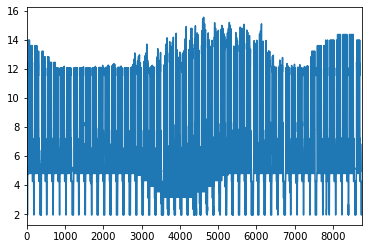

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m²
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5161283016204834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5251777172088623 sec


ERROR:root:Finished Generation of Irradiance


0.0


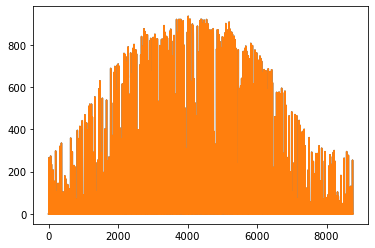

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.396665096282959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418720006942749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4075660705566406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


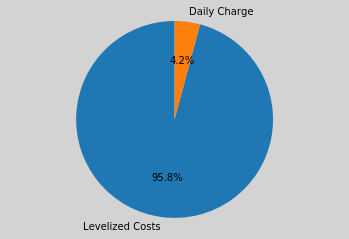

Total roof area of the  building: 599 m²
Total roof area used 473 m²
Percentage: 79.0%


In [16]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }

print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

61845.7

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [20]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

0

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [25]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Found the solver set
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 150, 200, 26, 46, 36, 0.5499999999999999, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4651598930358887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3322031497955322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.341630697250366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 13.0649, 289.331]


ERROR:ga_logger:Cost: 3136.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


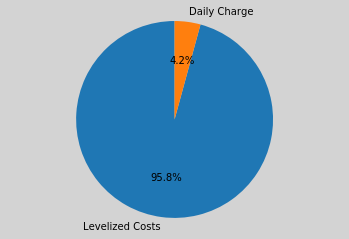

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 150, 200, 26, 46, 36, 0.5499999999999999, 0.6499999999999999, 0.49999999999999994, 3136.51, 302.39590000000004, 0.0, 13.0649, 289.331, {'Levelized Costs': 3003.457, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60374969022, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 265, 150, 51, 36, 16, 0.6499999999999999, 0.35, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3702216148376465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403635025024414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3858394622802734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [253.126, 0.0, 73.2679]


ERROR:ga_logger:Cost: 3374.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


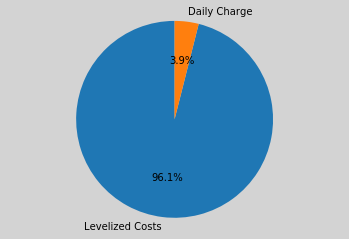

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 265, 150, 51, 36, 16, 0.6499999999999999, 0.35, 0.35, 3374.87, 326.39390000000003, 253.126, 0.0, 73.2679, {'Levelized Costs': 3241.81, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.597872466926, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 195, 125, 46, 21, 21, 0.5999999999999999, 0.25, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0536692142486572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6262779235839844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0714287757873535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [275.44, 34.9238, 0.0]


ERROR:ga_logger:Cost: 3215.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,216 per year


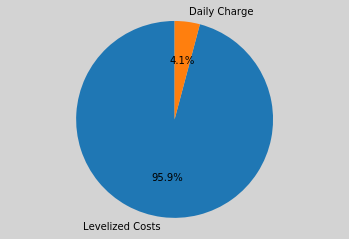

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[170, 195, 125, 46, 21, 21, 0.5999999999999999, 0.25, 0.7499999999999998, 3215.65, 310.36379999999997, 275.44, 34.9238, 0.0, {'Levelized Costs': 3082.5930000000003, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602451953346, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 115, 260, 6, 31, 36, 0.8499999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6951067447662354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0635859966278076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.148995876312256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [330.939, 0.0, 0.0]


ERROR:ga_logger:Cost: 3420.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,420 per year


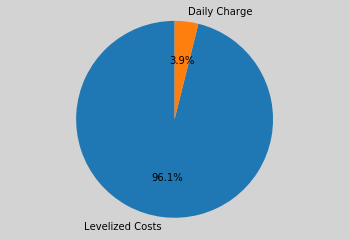

Total roof area of the  building: 599 m²
Total roof area used 389 m²
Percentage: 65.0%
[[235, 115, 260, 6, 31, 36, 0.8499999999999999, 0.5499999999999999, 0.35, 3420.01, 330.939, 330.939, 0.0, 0.0, {'Levelized Costs': 3286.954, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602914204625, 61845.7, 389.34]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 115, 205, 6, 21, 51, 0.49999999999999994, 0.7499999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0213325023651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.020857810974121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0369229316711426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [247.866, 77.2721, 0.0]


ERROR:ga_logger:Cost: 3362.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,362 per year


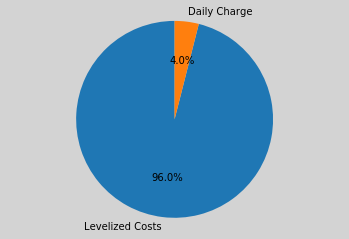

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[160, 115, 205, 6, 21, 51, 0.49999999999999994, 0.7499999999999998, 0.7999999999999998, 3362.39, 325.1381, 247.866, 77.2721, 0.0, {'Levelized Costs': 3229.337, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60415689005, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 135, 140, 46, 36, 56, 0.3, 0.7, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.040825843811035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0459840297698975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1725170612335205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [67.2163, 262.295, 0.0]


ERROR:ga_logger:Cost: 3405.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,406 per year


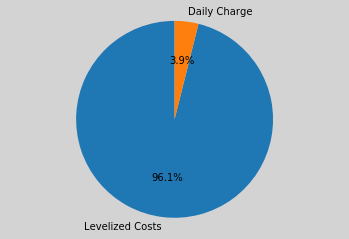

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 135, 140, 46, 36, 56, 0.3, 0.7, 0.35, 3405.83, 329.5113, 67.2163, 262.295, 0.0, {'Levelized Costs': 3272.7709999999997, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60065239305, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 245, 160, 51, 36, 56, 0.7, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.053899049758911 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1129722595214844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.017467737197876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 118.979, 225.985]


ERROR:ga_logger:Cost: 3559.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,559 per year


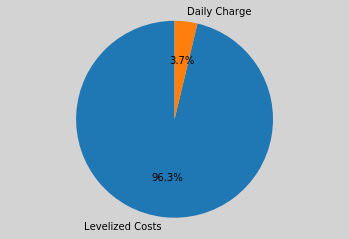

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 245, 160, 51, 36, 56, 0.7, 0.39999999999999997, 0.7499999999999998, 3559.31, 344.964, 0.0, 118.979, 225.985, {'Levelized Costs': 3426.253, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60180376006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 160, 110, 46, 36, 11, 0.5499999999999999, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.299330949783325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2868380546569824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.371533155441284 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3145.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0006 /kWh
Total Cost of the system: $ 3,146 per year


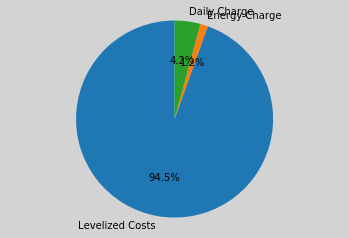

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 160, 110, 46, 36, 11, 0.5499999999999999, 0.49999999999999994, 0.39999999999999997, 3145.72, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.5079999999994, 'Energy Charge': 39.1700000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61533.10889779988, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 140, 165, 56, 26, 21, 0.39999999999999997, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42793869972229 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.396146774291992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.391676425933838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 316.026, 0.0]


ERROR:ga_logger:Cost: 3271.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,272 per year


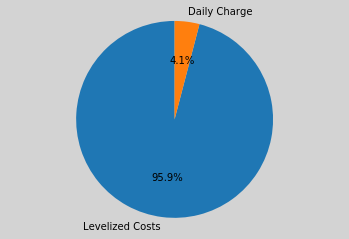

Total roof area of the  building: 599 m²
Total roof area used 486 m²
Percentage: 81.2%
[[260, 140, 165, 56, 26, 21, 0.39999999999999997, 0.6499999999999999, 0.8499999999999999, 3271.89, 316.026, 0.0, 316.026, 0.0, {'Levelized Costs': 3138.836, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601344790004, 61845.7, 486.194]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 250, 255, 36, 11, 56, 0.5999999999999999, 0.7, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5888476371765137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.818314790725708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4166042804718018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 333.67, 0.0]


ERROR:ga_logger:Cost: 3447.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,447 per year


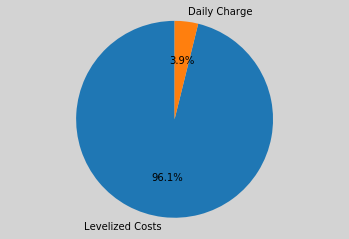

Total roof area of the  building: 599 m²
Total roof area used 477 m²
Percentage: 79.6%
[[120, 250, 255, 36, 11, 56, 0.5999999999999999, 0.7, 0.8999999999999999, 3447.14, 333.67, 0.0, 333.67, 0.0, {'Levelized Costs': 3314.084, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60070805053, 61845.7, 476.672]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 225, 155, 31, 21, 11, 0.7, 0.7, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.409968852996826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9719409942626953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.441499948501587 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 322.098, 0.0]


ERROR:ga_logger:Cost: 3332.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,332 per year


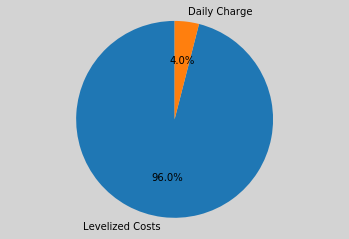

Total roof area of the  building: 599 m²
Total roof area used 460 m²
Percentage: 76.8%
[[220, 225, 155, 31, 21, 11, 0.7, 0.7, 0.8999999999999999, 3332.2, 322.098, 0.0, 322.098, 0.0, {'Levelized Costs': 3199.1499999999996, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60193752885, 61845.7, 460.14]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 145, 130, 11, 51, 36, 0.7499999999999998, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.169056177139282 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4411227703094482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.457523822784424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [204.443, 0.0, 114.16]


ERROR:ga_logger:Cost: 3297.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,297 per year


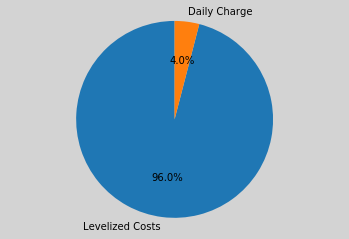

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 145, 130, 11, 51, 36, 0.7499999999999998, 0.7999999999999998, 0.35, 3297.49, 318.603, 204.443, 0.0, 114.16, {'Levelized Costs': 3164.4319999999993, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5987382399, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 165, 110, 41, 46, 56, 0.5999999999999999, 0.7499999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.401517868041992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.44085431098938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419264316558838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 326.229, 0.0]


ERROR:ga_logger:Cost: 3373.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,373 per year


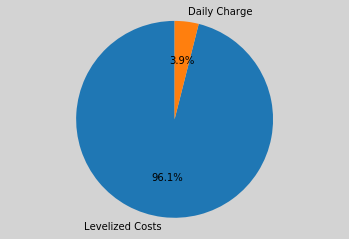

Total roof area of the  building: 599 m²
Total roof area used 435 m²
Percentage: 72.6%
[[100, 165, 110, 41, 46, 56, 0.5999999999999999, 0.7499999999999998, 0.35, 3373.23, 326.229, 0.0, 326.229, 0.0, {'Levelized Costs': 3240.178, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162190001, 61845.7, 434.972]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 125, 205, 56, 46, 6, 0.3, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.54553484916687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4165308475494385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.859302043914795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 277.094, 88.3381]


ERROR:ga_logger:Cost: 3762.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,763 per year


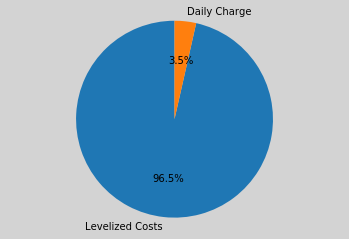

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 125, 205, 56, 46, 6, 0.3, 0.7999999999999998, 0.35, 3762.6, 365.4321, 0.0, 277.094, 88.3381, {'Levelized Costs': 3629.549, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60069938004, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 205, 135, 36, 16, 51, 0.8999999999999999, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5168747901916504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5329806804656982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4284210205078125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 314.003, 0.0]


ERROR:ga_logger:Cost: 3251.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,252 per year


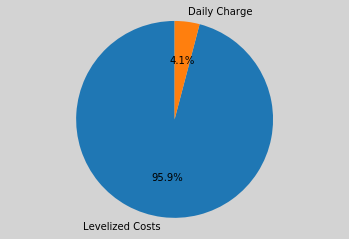

Total roof area of the  building: 599 m²
Total roof area used 419 m²
Percentage: 69.9%
[[125, 205, 135, 36, 16, 51, 0.8999999999999999, 0.7499999999999998, 0.49999999999999994, 3251.79, 314.003, 0.0, 314.003, 0.0, {'Levelized Costs': 3118.7239999999997, 'Energy Charge': 0.024000000000228283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60198726154, 61845.7, 418.67]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 135, 130, 26, 56, 56, 0.35, 0.35, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4560999870300293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.388563632965088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4033679962158203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [209.567, 0.0, 0.0]


ERROR:ga_logger:Cost: 4445.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0361 /kWh
Total Cost of the system: $ 4,445 per year


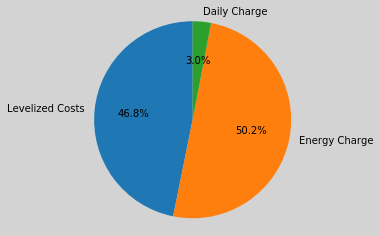

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 135, 130, 26, 56, 56, 0.35, 0.35, 0.3, 4445.03, 209.567, 209.567, 0.0, 0.0, {'Levelized Costs': 2081.4549999999995, 'Energy Charge': 2230.5330000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 44044.16652079994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 110, 200, 26, 16, 26, 0.39999999999999997, 0.5999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454073905944824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3680548667907715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5046913623809814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [175.465, 0.0, 136.084]


ERROR:ga_logger:Cost: 3227.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,227 per year


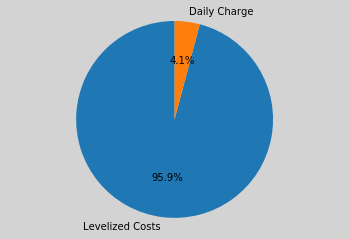

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 110, 200, 26, 16, 26, 0.39999999999999997, 0.5999999999999999, 0.8499999999999999, 3227.42, 311.549, 175.465, 0.0, 136.084, {'Levelized Costs': 3094.363, 'Energy Charge': 0.015000000000441105, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602437874026, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 175, 95, 11, 6, 41, 0.7999999999999998, 0.25, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5209767818450928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3756449222564697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4171175956726074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [264.656, 66.9854, 0.0]


ERROR:ga_logger:Cost: 3426.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,427 per year


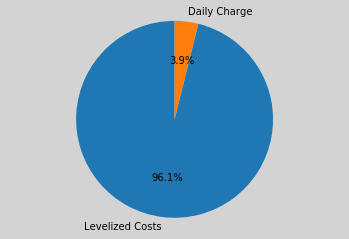

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 175, 95, 11, 6, 41, 0.7999999999999998, 0.25, 0.7999999999999998, 3426.99, 331.6414, 264.656, 66.9854, 0.0, {'Levelized Costs': 3293.928, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59991228999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 260, 220, 21, 11, 51, 0.7, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4851231575012207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4657223224639893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3916826248168945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 124s


ERROR:ga_logger:panel relevance: [305.075, 0.0, 0.0]


ERROR:ga_logger:Cost: 3163.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,163 per year


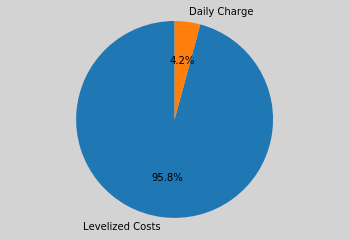

Total roof area of the  building: 599 m²
Total roof area used 436 m²
Percentage: 72.8%
[[175, 260, 220, 21, 11, 51, 0.7, 0.44999999999999996, 0.7999999999999998, 3163.12, 305.075, 305.075, 0.0, 0.0, {'Levelized Costs': 3030.0659999999993, 'Energy Charge': 0.012000000000398359, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60331829288, 61845.7, 435.821]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 190, 195, 31, 51, 51, 0.44999999999999996, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.522449016571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4197185039520264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3799686431884766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [172.676, 0.0, 139.774]


ERROR:ga_logger:Cost: 3236.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,236 per year


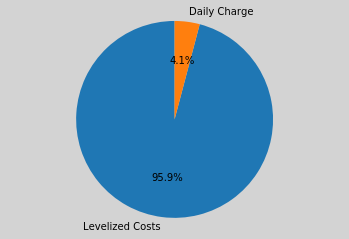

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 190, 195, 31, 51, 51, 0.44999999999999996, 0.8999999999999999, 0.6499999999999999, 3236.37, 312.45, 172.676, 0.0, 139.774, {'Levelized Costs': 3103.3169999999996, 'Energy Charge': 0.011000000000251475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600341821926, 61845.7, 598.762]]


ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 210, 105, 11, 41, 21, 0.25, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4510226249694824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4344139099121094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3656811714172363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [43.0484, 277.269, 0.0]


ERROR:ga_logger:Cost: 3314.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


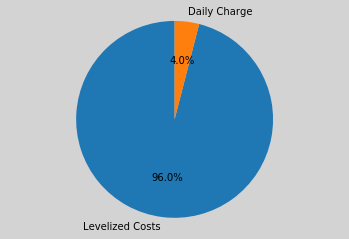

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 210, 105, 11, 41, 21, 0.25, 0.6499999999999999, 0.7999999999999998, 3314.52, 320.3174, 43.0484, 277.269, 0.0, {'Levelized Costs': 3181.461, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6022764887, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 130, 120, 11, 26, 11, 0.7999999999999998, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5468380451202393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366828680038452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3519515991210938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [320.037, 0.0, 0.0]


ERROR:ga_logger:Cost: 3311.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,312 per year


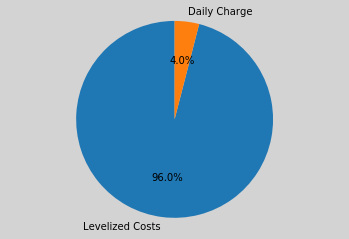

Total roof area of the  building: 599 m²
Total roof area used 400 m²
Percentage: 66.8%
[[210, 130, 120, 11, 26, 11, 0.7999999999999998, 0.8499999999999999, 0.7, 3311.73, 320.037, 320.037, 0.0, 0.0, {'Levelized Costs': 3178.674, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60293969052, 61845.7, 400.047]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 135, 180, 31, 26, 1, 0.6499999999999999, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.489488124847412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3978683948516846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.563969135284424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 319.669, 0.0]


ERROR:ga_logger:Cost: 3308.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


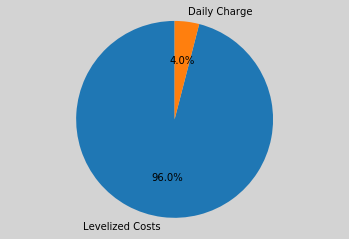

Total roof area of the  building: 599 m²
Total roof area used 492 m²
Percentage: 82.1%
[[225, 135, 180, 31, 26, 1, 0.6499999999999999, 0.6499999999999999, 0.35, 3308.08, 319.669, 0.0, 319.669, 0.0, {'Levelized Costs': 3175.018, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59961748553, 61845.7, 491.799]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 195, 160, 51, 26, 16, 0.2, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5624756813049316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42903995513916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373918056488037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 154s


ERROR:ga_logger:panel relevance: [0.0, 137.034, 170.988]


ERROR:ga_logger:Cost: 3192.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,192 per year


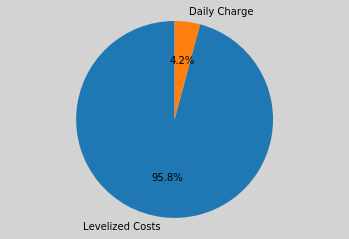

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 195, 160, 51, 26, 16, 0.2, 0.7999999999999998, 0.39999999999999997, 3192.39, 308.022, 0.0, 137.034, 170.988, {'Levelized Costs': 3059.325, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600355106144, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 250, 180, 56, 6, 31, 0.35, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4803857803344727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6670498847961426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3733162879943848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.677]


ERROR:ga_logger:Cost: 3129.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,129 per year


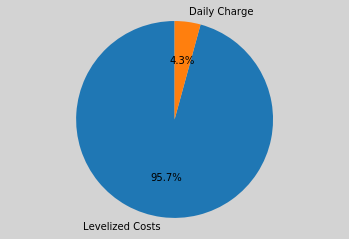

Total roof area of the  building: 599 m²
Total roof area used 464 m²
Percentage: 77.5%
[[220, 250, 180, 56, 6, 31, 0.35, 0.44999999999999996, 0.6499999999999999, 3129.37, 301.677, 0.0, 0.0, 301.677, {'Levelized Costs': 2996.313, 'Energy Charge': 0.014999999999929514, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60252790339, 61845.7, 464.119]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 175, 165, 11, 56, 41, 0.6499999999999999, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459470272064209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.532196283340454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.488431692123413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.382]


ERROR:ga_logger:Cost: 3195.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,196 per year


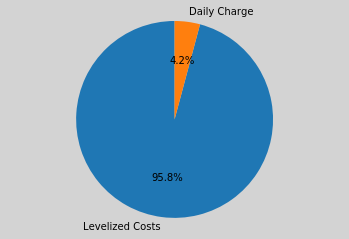

Total roof area of the  building: 599 m²
Total roof area used 514 m²
Percentage: 85.8%
[[110, 175, 165, 11, 56, 41, 0.6499999999999999, 0.3, 0.5999999999999999, 3195.96, 308.382, 0.0, 0.0, 308.382, {'Levelized Costs': 3062.909, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600015499935, 61845.7, 513.969]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 265, 130, 11, 46, 41, 0.39999999999999997, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4783670902252197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.38299298286438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.390355348587036 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [239.505, 0.0, 0.0]


ERROR:ga_logger:Cost: 4273.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0285 /kWh
Total Cost of the system: $ 4,274 per year


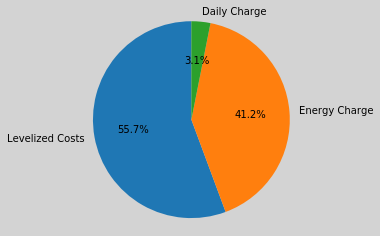

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[170, 265, 130, 11, 46, 41, 0.39999999999999997, 0.49999999999999994, 0.39999999999999997, 4273.85, 239.505, 239.505, 0.0, 0.0, {'Levelized Costs': 2378.8070000000002, 'Energy Charge': 1762.001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 47783.45601813011, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 175, 110, 56, 36, 21, 0.3, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5448074340820312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.515026092529297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5111753940582275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 325.052, 0.0]


ERROR:ga_logger:Cost: 3361.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,362 per year


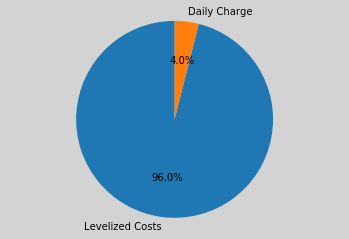

Total roof area of the  building: 599 m²
Total roof area used 361 m²
Percentage: 60.3%
[[240, 175, 110, 56, 36, 21, 0.3, 0.8999999999999999, 0.49999999999999994, 3361.54, 325.052, 0.0, 325.052, 0.0, {'Levelized Costs': 3228.491, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60259737296, 61845.7, 361.169]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 255, 225, 21, 1, 21, 0.25, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.11551308631897 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5645499229431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.051142930984497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 149.69]


ERROR:ga_logger:Cost: 5639.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0650 /kWh
Total Cost of the system: $ 5,640 per year


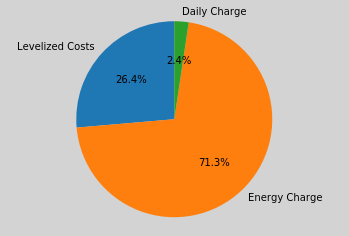

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 255, 225, 21, 1, 21, 0.25, 0.49999999999999994, 0.25, 5639.52, 149.69, 0.0, 0.0, 149.69, {'Levelized Costs': 1486.7566000000006, 'Energy Charge': 4019.7214, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 29764.94222689428, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 205, 170, 46, 46, 31, 0.7499999999999998, 0.5999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5558831691741943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.352289915084839 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3815853595733643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.387]


ERROR:ga_logger:Cost: 3146.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,146 per year


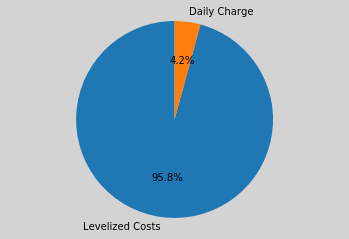

Total roof area of the  building: 599 m²
Total roof area used 467 m²
Percentage: 78.0%
[[150, 205, 170, 46, 46, 31, 0.7499999999999998, 0.5999999999999999, 0.6499999999999999, 3146.35, 303.387, 0.0, 0.0, 303.387, {'Levelized Costs': 3013.294, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60091608981, 61845.7, 466.749]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 185, 125, 46, 6, 26, 0.8999999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.600456953048706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4142324924468994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.395479679107666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 303.892, 16.1807]


ERROR:ga_logger:Cost: 3312.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,312 per year


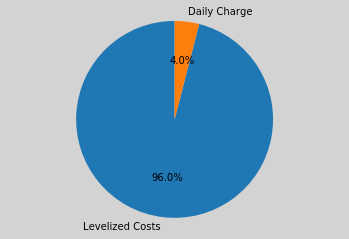

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 185, 125, 46, 6, 26, 0.8999999999999999, 0.5499999999999999, 0.35, 3312.08, 320.0727, 0.0, 303.892, 16.1807, {'Levelized Costs': 3179.0229999999997, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60215175114, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 180, 105, 36, 51, 26, 0.8499999999999999, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4393556118011475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.293020486831665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2904603481292725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 61.3848, 277.411]


ERROR:ga_logger:Cost: 3498.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,498 per year


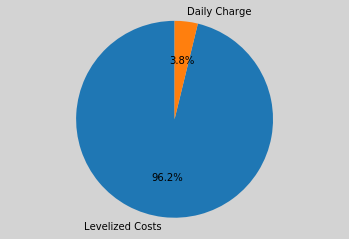

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[260, 180, 105, 36, 51, 26, 0.8499999999999999, 0.44999999999999996, 0.5999999999999999, 3498.04, 338.7958, 0.0, 61.3848, 277.411, {'Levelized Costs': 3364.9739999999997, 'Energy Charge': 0.024000000000228283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209185001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 110, 140, 1, 41, 6, 0.6499999999999999, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5933995246887207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.298710823059082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2972545623779297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.561]


ERROR:ga_logger:Cost: 3346.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,347 per year


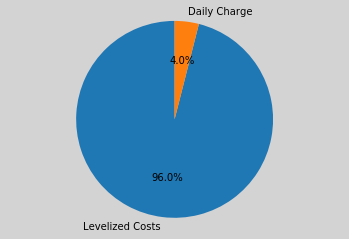

Total roof area of the  building: 599 m²
Total roof area used 498 m²
Percentage: 83.1%
[[245, 110, 140, 1, 41, 6, 0.6499999999999999, 0.44999999999999996, 0.6499999999999999, 3346.72, 323.561, 0.0, 0.0, 323.561, {'Levelized Costs': 3213.6609999999996, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600439452086, 61845.7, 497.785]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 150, 200, 21, 51, 36, 0.5499999999999999, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.08466100692749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.302675247192383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.29794979095459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [217.634, 0.0, 81.2256]


ERROR:ga_logger:Cost: 3101.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,101 per year


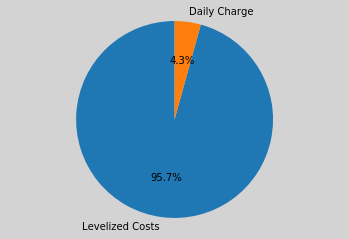

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 150, 200, 21, 51, 36, 0.5499999999999999, 0.7, 0.39999999999999997, 3101.39, 298.8596, 217.634, 0.0, 81.2256, {'Levelized Costs': 2968.336, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59915259792, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 175, 155, 41, 41, 16, 0.2, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.542696237564087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3366317749023438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.27217173576355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 42.482, 262.562]


ERROR:ga_logger:Cost: 3162.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,163 per year


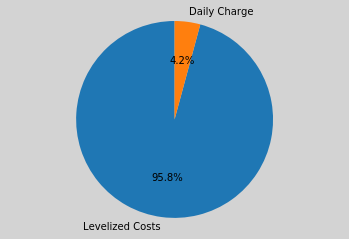

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 175, 155, 41, 41, 16, 0.2, 0.35, 0.5499999999999999, 3162.81, 305.044, 0.0, 42.482, 262.562, {'Levelized Costs': 3029.751, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600041849946, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 100, 215, 41, 51, 46, 0.7999999999999998, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5352530479431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3242409229278564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323620080947876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.596]


ERROR:ga_logger:Cost: 3366.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,367 per year


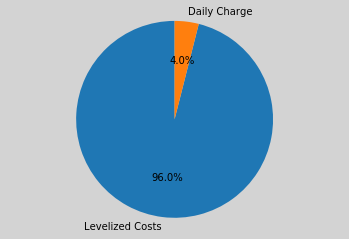

Total roof area of the  building: 599 m²
Total roof area used 592 m²
Percentage: 98.9%
[[210, 100, 215, 41, 51, 46, 0.7999999999999998, 0.3, 0.5499999999999999, 3366.94, 325.596, 0.0, 0.0, 325.596, {'Levelized Costs': 3233.881, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60201459269, 61845.7, 591.992]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 160, 220, 36, 11, 16, 0.25, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.572739839553833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.292210578918457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3237030506134033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [56.2691, 0.0, 261.58]


ERROR:ga_logger:Cost: 3289.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,290 per year


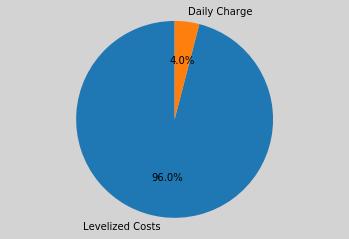

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 160, 220, 36, 11, 16, 0.25, 0.8499999999999999, 0.7, 3289.99, 317.84909999999996, 56.2691, 0.0, 261.58, {'Levelized Costs': 3156.931, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59983937122, 61845.7, 598.762]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 195, 90, 51, 6, 1, 0.6499999999999999, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462390184402466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2507729530334473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.291898012161255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 322.4, 0.0]


ERROR:ga_logger:Cost: 3335.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


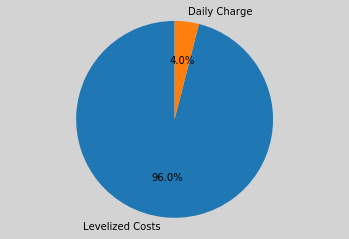

Total roof area of the  building: 599 m²
Total roof area used 403 m²
Percentage: 67.3%
[[95, 195, 90, 51, 6, 1, 0.6499999999999999, 0.7999999999999998, 0.6499999999999999, 3335.2, 322.4, 0.0, 322.4, 0.0, {'Levelized Costs': 3202.1459999999997, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60196774088, 61845.7, 403.0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 265, 150, 26, 6, 41, 0.44999999999999996, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 26.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.474635601043701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.601320266723633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1994688510894775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [269.443, 0.0, 0.0]


ERROR:ga_logger:Cost: 3626.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0132 /kWh
Total Cost of the system: $ 3,626 per year


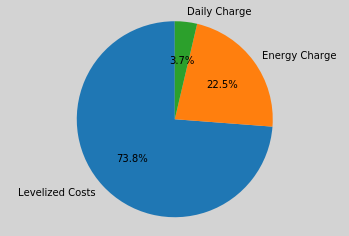

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 265, 150, 26, 6, 41, 0.44999999999999996, 0.35, 0.39999999999999997, 3626.48, 269.443, 269.443, 0.0, 0.0, {'Levelized Costs': 2676.163, 'Energy Charge': 817.2750000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55323.15978543593, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 265, 125, 11, 56, 36, 0.7499999999999998, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 11.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4731976985931396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2145938873291016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2269296646118164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [327.79, 0.0, 0.0]


ERROR:ga_logger:Cost: 3388.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,389 per year


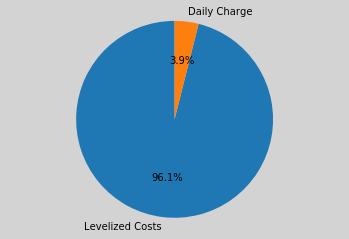

Total roof area of the  building: 599 m²
Total roof area used 437 m²
Percentage: 73.0%
[[120, 265, 125, 11, 56, 36, 0.7499999999999998, 0.7, 0.5499999999999999, 3388.73, 327.79, 327.79, 0.0, 0.0, {'Levelized Costs': 3255.667, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59991011998, 61845.7, 437.053]]


ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 175, 135, 56, 56, 51, 0.35, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5174076557159424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2235913276672363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.183422565460205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 326.451, 0.0]


ERROR:ga_logger:Cost: 3375.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


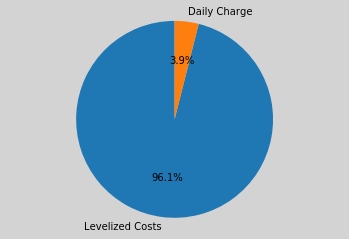

Total roof area of the  building: 599 m²
Total roof area used 544 m²
Percentage: 90.9%
[[95, 175, 135, 56, 56, 51, 0.35, 0.5999999999999999, 0.7499999999999998, 3375.43, 326.451, 0.0, 326.451, 0.0, {'Levelized Costs': 3242.374, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60248549998, 61845.7, 544.084]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 215, 95, 36, 31, 26, 0.2, 0.2, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 36.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5611631870269775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2842299938201904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2265493869781494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 21.8011, 342.829]


ERROR:ga_logger:Cost: 3754.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,755 per year


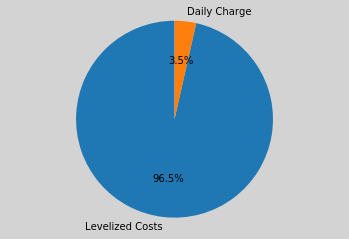

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 215, 95, 36, 31, 26, 0.2, 0.2, 0.7, 3754.64, 364.6301, 0.0, 21.8011, 342.829, {'Levelized Costs': 3621.5809999999997, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60039289993, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 195, 135, 1, 41, 16, 0.5999999999999999, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6252918243408203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.248326539993286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.195622682571411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 311.037, 0.0]


ERROR:ga_logger:Cost: 3222.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


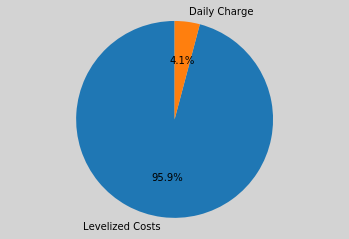

Total roof area of the  building: 599 m²
Total roof area used 479 m²
Percentage: 79.9%
[[260, 195, 135, 1, 41, 16, 0.5999999999999999, 0.6499999999999999, 0.7999999999999998, 3222.34, 311.037, 0.0, 311.037, 0.0, {'Levelized Costs': 3089.288, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602159178256, 61845.7, 478.518]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 120, 150, 26, 36, 56, 0.49999999999999994, 0.49999999999999994, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6644394397735596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.227182626724243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2303507328033447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.319]


ERROR:ga_logger:Cost: 3590.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0030 /kWh
Total Cost of the system: $ 3,590 per year


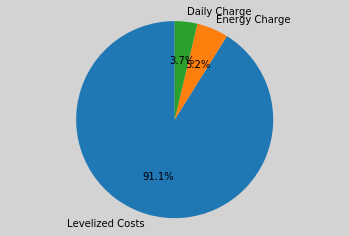

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[250, 120, 150, 26, 36, 56, 0.49999999999999994, 0.49999999999999994, 0.5499999999999999, 3590.25, 329.319, 0.0, 0.0, 329.319, {'Levelized Costs': 3270.861, 'Energy Charge': 186.3470000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60358.4935111401, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 265, 220, 16, 11, 51, 0.8999999999999999, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7861690521240234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.691561460494995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.240063428878784 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 128s


ERROR:ga_logger:panel relevance: [325.252, 0.0, 0.0]


ERROR:ga_logger:Cost: 3363.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,364 per year


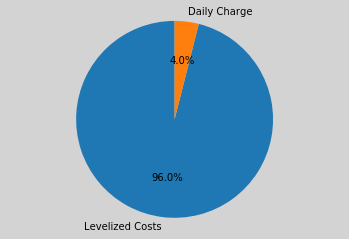

Total roof area of the  building: 599 m²
Total roof area used 361 m²
Percentage: 60.4%
[[155, 265, 220, 16, 11, 51, 0.8999999999999999, 0.5499999999999999, 0.39999999999999997, 3363.53, 325.252, 325.252, 0.0, 0.0, {'Levelized Costs': 3230.478, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60270398527, 61845.7, 361.392]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 245, 165, 21, 6, 46, 0.44999999999999996, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5522780418395996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5135295391082764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2394440174102783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 269.443]


ERROR:ga_logger:Cost: 3702.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0144 /kWh
Total Cost of the system: $ 3,703 per year


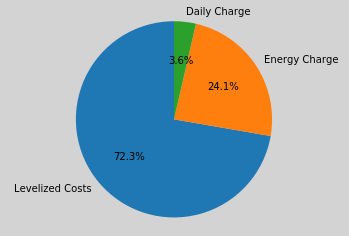

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 245, 165, 21, 6, 46, 0.44999999999999996, 0.39999999999999997, 0.44999999999999996, 3702.77, 269.443, 0.0, 0.0, 269.443, {'Levelized Costs': 2676.1549999999997, 'Energy Charge': 893.5730000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54714.24954239998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 170, 215, 16, 51, 41, 0.7, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6030304431915283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.198763370513916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.297213077545166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [114.796, 195.645, 0.0]


ERROR:ga_logger:Cost: 3216.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,216 per year


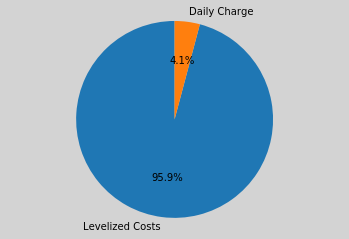

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[205, 170, 215, 16, 51, 41, 0.7, 0.44999999999999996, 0.6499999999999999, 3216.42, 310.44100000000003, 114.796, 195.645, 0.0, {'Levelized Costs': 3083.363, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6009346665, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 260, 215, 11, 11, 21, 0.8499999999999999, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.848630905151367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.30617356300354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8930866718292236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.483]


ERROR:ga_logger:Cost: 3206.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,207 per year


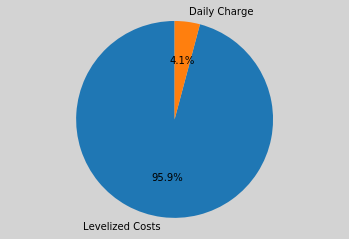

Total roof area of the  building: 599 m²
Total roof area used 563 m²
Percentage: 94.0%
[[190, 260, 215, 11, 11, 21, 0.8499999999999999, 0.44999999999999996, 0.5499999999999999, 3206.9, 309.483, 0.0, 0.0, 309.483, {'Levelized Costs': 3073.8459999999995, 'Energy Charge': 0.012000000000455202, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60267870262, 61845.7, 562.696]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 105, 240, 26, 56, 46, 0.5499999999999999, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.686384439468384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.218533754348755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.290062189102173 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [299.492, 0.0, 0.0]


ERROR:ga_logger:Cost: 3107.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,108 per year


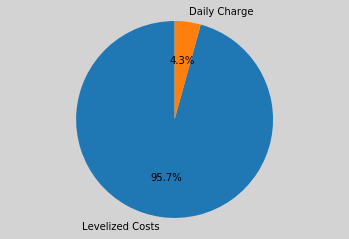

Total roof area of the  building: 599 m²
Total roof area used 545 m²
Percentage: 90.9%
[[195, 105, 240, 26, 56, 46, 0.5499999999999999, 0.5499999999999999, 0.2, 3107.67, 299.492, 299.492, 0.0, 0.0, {'Levelized Costs': 2974.6150000000002, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60364454502, 61845.7, 544.531]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 105, 100, 46, 26, 11, 0.44999999999999996, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.692164897918701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.240753650665283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2489447593688965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 337.91]


ERROR:ga_logger:Cost: 3489.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,489 per year


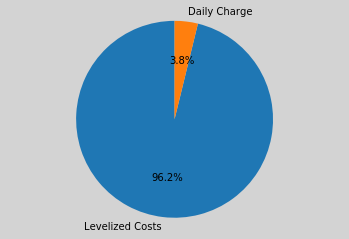

Total roof area of the  building: 599 m²
Total roof area used 451 m²
Percentage: 75.2%
[[100, 105, 100, 46, 26, 11, 0.44999999999999996, 0.49999999999999994, 0.7499999999999998, 3489.24, 337.91, 0.0, 0.0, 337.91, {'Levelized Costs': 3356.1849999999995, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601158929654, 61845.7, 450.546]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 190, 175, 1, 16, 41, 0.6499999999999999, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7365474700927734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.301375389099121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.250169038772583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 239.505]


ERROR:ga_logger:Cost: 3990.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0239 /kWh
Total Cost of the system: $ 3,991 per year


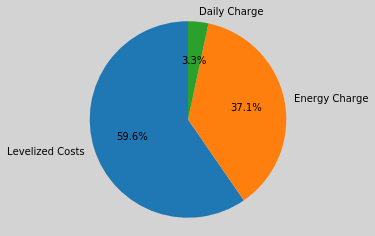

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 190, 175, 1, 16, 41, 0.6499999999999999, 0.35, 0.39999999999999997, 3990.57, 239.505, 0.0, 0.0, 239.505, {'Levelized Costs': 2378.8089999999997, 'Energy Charge': 1478.7190000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50044.28442930017, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 135, 145, 41, 36, 21, 0.5499999999999999, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7166411876678467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.247227430343628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2301173210144043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 213.61, 116.112]


ERROR:ga_logger:Cost: 3407.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,408 per year


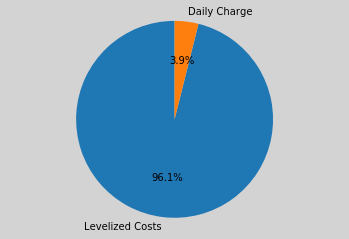

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[235, 135, 145, 41, 36, 21, 0.5499999999999999, 0.7999999999999998, 0.35, 3407.92, 329.722, 0.0, 213.61, 116.112, {'Levelized Costs': 3274.8529999999996, 'Energy Charge': 0.025000000000318323, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59988007987, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 245, 90, 26, 6, 16, 0.7499999999999998, 0.2, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6573054790496826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2892565727233887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2359824180603027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [289.563, 42.5357, 0.0]


ERROR:ga_logger:Cost: 3431.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,432 per year


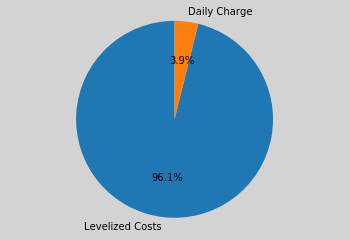

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 245, 90, 26, 6, 16, 0.7499999999999998, 0.2, 0.5999999999999999, 3431.52, 332.0987, 289.563, 42.5357, 0.0, {'Levelized Costs': 3298.4660000000003, 'Energy Charge': 0.011999999999886768, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60115307009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 115, 155, 46, 41, 31, 0.8499999999999999, 0.5999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4559154510498047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0065784454345703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.048401117324829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.087]


ERROR:ga_logger:Cost: 3242.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


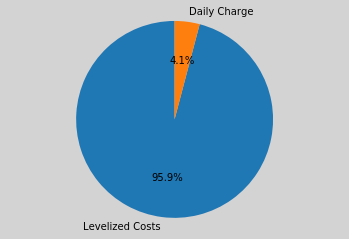

Total roof area of the  building: 599 m²
Total roof area used 447 m²
Percentage: 74.7%
[[155, 115, 155, 46, 41, 31, 0.8499999999999999, 0.5999999999999999, 0.7, 3242.69, 313.087, 0.0, 0.0, 313.087, {'Levelized Costs': 3109.631, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60192150023, 61845.7, 447.266]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 260, 240, 6, 11, 31, 0.49999999999999994, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4417471885681152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0549871921539307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0321285724639893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [255.701, 78.6236, 0.0]


ERROR:ga_logger:Cost: 3453.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,454 per year


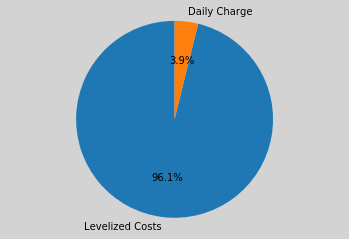

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 260, 240, 6, 11, 31, 0.49999999999999994, 0.8999999999999999, 0.5999999999999999, 3453.64, 334.3246, 255.701, 78.6236, 0.0, {'Levelized Costs': 3320.573, 'Energy Charge': 0.025000000000318323, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601695417536, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 165, 225, 41, 41, 16, 0.2, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.515887498855591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.01861834526062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0123627185821533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 221.239, 85.6964]


ERROR:ga_logger:Cost: 3181.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,182 per year


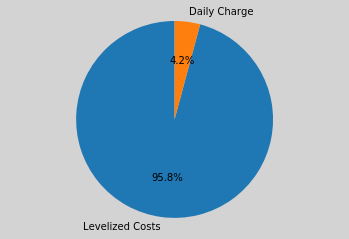

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[170, 165, 225, 41, 41, 16, 0.2, 0.44999999999999996, 0.7999999999999998, 3181.6, 306.9354, 0.0, 221.239, 85.6964, {'Levelized Costs': 3048.544, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60220353236, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 170, 245, 36, 41, 46, 0.39999999999999997, 0.8499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5316851139068604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0138800144195557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.005847930908203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [179.633, 127.227, 0.0]


ERROR:ga_logger:Cost: 3180.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,181 per year


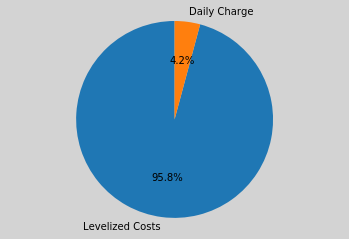

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[190, 170, 245, 36, 41, 46, 0.39999999999999997, 0.8499999999999999, 0.5499999999999999, 3180.85, 306.86, 179.633, 127.227, 0.0, {'Levelized Costs': 3047.797, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60060836143, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 95, 210, 31, 11, 26, 0.35, 0.5999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.58319091796875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9712886810302734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.088684320449829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 222.833, 102.318]


ERROR:ga_logger:Cost: 3362.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,363 per year


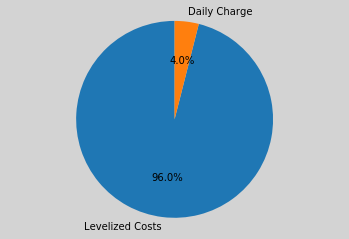

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 95, 210, 31, 11, 26, 0.35, 0.5999999999999999, 0.44999999999999996, 3362.52, 325.151, 0.0, 222.833, 102.318, {'Levelized Costs': 3229.4669999999996, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60203909015, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 110, 220, 31, 41, 36, 0.35, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5382778644561768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0679211616516113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.040742874145508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 295.275, 70.776]


ERROR:ga_logger:Cost: 3768.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,769 per year


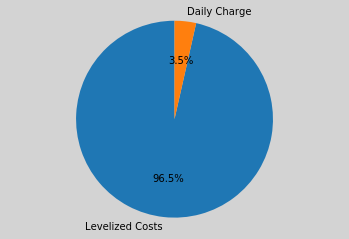

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 110, 220, 31, 41, 36, 0.35, 0.7, 0.39999999999999997, 3768.75, 366.051, 0.0, 295.275, 70.776, {'Levelized Costs': 3635.696, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60244979984, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 210, 180, 21, 16, 26, 0.7, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5813024044036865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0376241207122803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0288310050964355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.49]


ERROR:ga_logger:Cost: 3087.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,088 per year


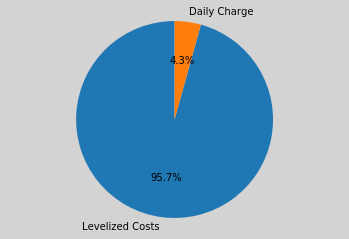

Total roof area of the  building: 599 m²
Total roof area used 541 m²
Percentage: 90.3%
[[125, 210, 180, 21, 16, 26, 0.7, 0.7999999999999998, 0.5499999999999999, 3087.78, 297.49, 0.0, 0.0, 297.49, {'Levelized Costs': 2954.722, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6010368, 61845.7, 540.89]]


ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 160, 245, 56, 36, 56, 0.5999999999999999, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.581569194793701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0387160778045654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.011796474456787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 328.215, 0.0]


ERROR:ga_logger:Cost: 3392.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,393 per year


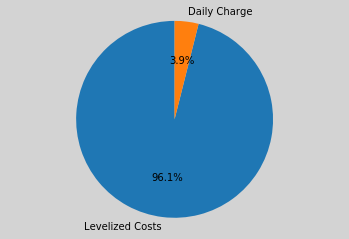

Total roof area of the  building: 599 m²
Total roof area used 386 m²
Percentage: 64.5%
[[250, 160, 245, 56, 36, 56, 0.5999999999999999, 0.8499999999999999, 0.8999999999999999, 3392.96, 328.215, 0.0, 328.215, 0.0, {'Levelized Costs': 3259.908, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601606400196, 61845.7, 386.136]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 150, 230, 51, 36, 41, 0.39999999999999997, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6066668033599854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.085360288619995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0871973037719727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 259.311, 77.6596]


ERROR:ga_logger:Cost: 3479.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,480 per year


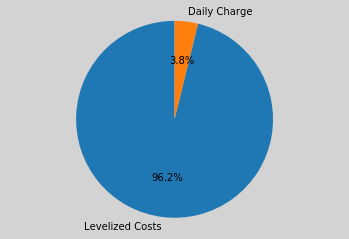

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 150, 230, 51, 36, 41, 0.39999999999999997, 0.8999999999999999, 0.25, 3479.92, 336.9706, 0.0, 259.311, 77.6596, {'Levelized Costs': 3346.8619999999996, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60080700515, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 125, 150, 6, 31, 1, 0.35, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0115931034088135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0395374298095703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.115355968475342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [134.098, 0.0, 194.061]


ERROR:ga_logger:Cost: 3392.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,392 per year


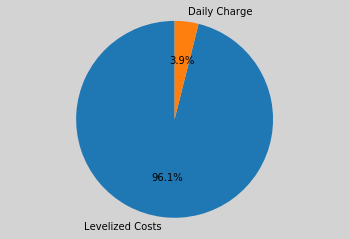

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[190, 125, 150, 6, 31, 1, 0.35, 0.8499999999999999, 0.8999999999999999, 3392.4, 328.159, 134.098, 0.0, 194.061, {'Levelized Costs': 3259.342, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603899873946, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 105, 185, 16, 41, 36, 0.35, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6677067279815674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0154380798339844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.045614719390869 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.83]


ERROR:ga_logger:Cost: 3071.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


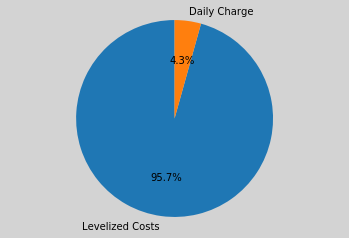

Total roof area of the  building: 599 m²
Total roof area used 592 m²
Percentage: 98.8%
[[230, 105, 185, 16, 41, 36, 0.35, 0.39999999999999997, 0.49999999999999994, 3071.29, 295.83, 0.0, 0.0, 295.83, {'Levelized Costs': 2938.23, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60212743698, 61845.7, 591.659]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 140, 255, 11, 6, 56, 0.39999999999999997, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6788926124572754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.975573778152466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0452115535736084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [170.156, 147.365, 0.0]


ERROR:ga_logger:Cost: 3286.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,287 per year


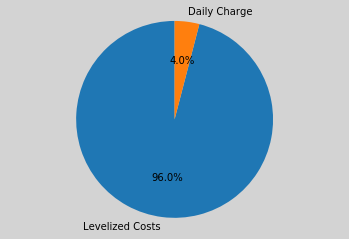

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 140, 255, 11, 6, 56, 0.39999999999999997, 0.8499999999999999, 0.25, 3286.74, 317.521, 170.156, 147.365, 0.0, {'Levelized Costs': 3153.6879999999996, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6012513127, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 180, 260, 41, 56, 46, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6132235527038574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.027106761932373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.993495225906372 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 339.954, 0.0]


ERROR:ga_logger:Cost: 3509.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,510 per year


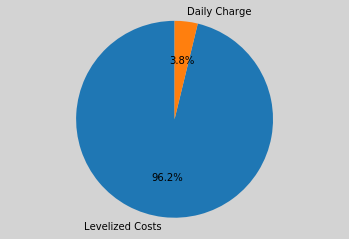

Total roof area of the  building: 599 m²
Total roof area used 425 m²
Percentage: 71.0%
[[135, 180, 260, 41, 56, 46, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999, 3509.55, 339.954, 0.0, 339.954, 0.0, {'Levelized Costs': 3376.495, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60113333999, 61845.7, 424.943]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 165, 215, 26, 46, 16, 0.5999999999999999, 0.5999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8001632690429688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1193196773529053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.155472755432129 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 313.945, 0.0]


ERROR:ga_logger:Cost: 3251.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,251 per year


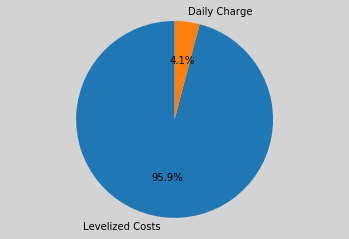

Total roof area of the  building: 599 m²
Total roof area used 523 m²
Percentage: 87.4%
[[240, 165, 215, 26, 46, 16, 0.5999999999999999, 0.5999999999999999, 0.6499999999999999, 3251.22, 313.945, 0.0, 313.945, 0.0, {'Levelized Costs': 3118.1679999999997, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601508699845, 61845.7, 523.242]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 100, 215, 6, 11, 11, 0.7999999999999998, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9631011486053467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345940351486206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444913148880005 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [278.027, 0.0, 50.2457]


ERROR:ga_logger:Cost: 3393.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,394 per year


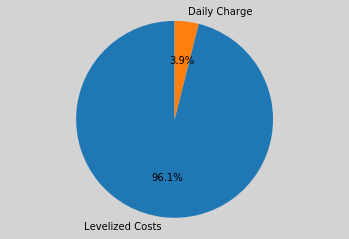

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 100, 215, 6, 11, 11, 0.7999999999999998, 0.5999999999999999, 0.2, 3393.52, 328.2727, 278.027, 0.0, 50.2457, {'Levelized Costs': 3260.466, 'Energy Charge': 0.012000000000398359, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60112571569, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 215, 225, 31, 26, 21, 0.5499999999999999, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.112402677536011 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.449279308319092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9438517093658447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 309.077, 0.0]


ERROR:ga_logger:Cost: 3202.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


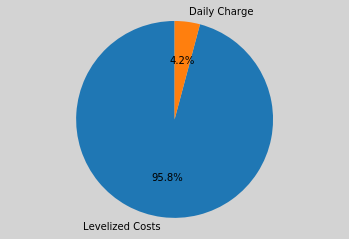

Total roof area of the  building: 599 m²
Total roof area used 562 m²
Percentage: 93.9%
[[250, 215, 225, 31, 26, 21, 0.5499999999999999, 0.5499999999999999, 0.39999999999999997, 3202.87, 309.077, 0.0, 309.077, 0.0, {'Levelized Costs': 3069.801, 'Energy Charge': 0.027000000000157343, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59818978129, 61845.7, 561.958]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 260, 125, 11, 51, 6, 0.5499999999999999, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.506685256958008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3680129051208496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.394054651260376 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [322.073, 0.0, 0.0]


ERROR:ga_logger:Cost: 3331.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,332 per year


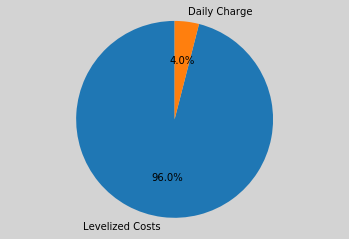

Total roof area of the  building: 599 m²
Total roof area used 586 m²
Percentage: 97.8%
[[230, 260, 125, 11, 51, 6, 0.5499999999999999, 0.7999999999999998, 0.44999999999999996, 3331.95, 322.073, 322.073, 0.0, 0.0, {'Levelized Costs': 3198.894, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599720334365, 61845.7, 585.588]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 135, 185, 56, 46, 31, 0.5999999999999999, 0.25, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 56.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0985918045043945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.405555248260498 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.420780897140503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.487]


ERROR:ga_logger:Cost: 3077.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,078 per year


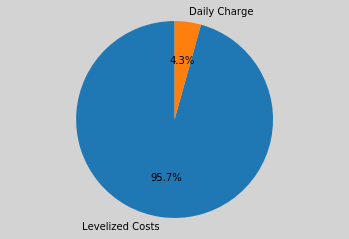

Total roof area of the  building: 599 m²
Total roof area used 539 m²
Percentage: 90.0%
[[140, 135, 185, 56, 46, 31, 0.5999999999999999, 0.25, 0.5499999999999999, 3077.82, 296.487, 0.0, 0.0, 296.487, {'Levelized Costs': 2944.762, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60094080127, 61845.7, 539.067]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 155, 105, 56, 36, 1, 0.8999999999999999, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1661107540130615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3953559398651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4378342628479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 321.357, 0.0]


ERROR:ga_logger:Cost: 3324.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


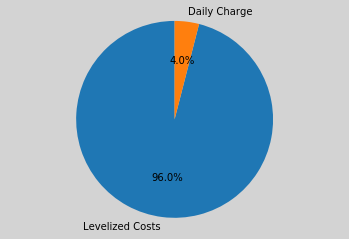

Total roof area of the  building: 599 m²
Total roof area used 428 m²
Percentage: 71.6%
[[180, 155, 105, 56, 36, 1, 0.8999999999999999, 0.7499999999999998, 0.5499999999999999, 3324.84, 321.357, 0.0, 321.357, 0.0, {'Levelized Costs': 3191.784, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59962438007, 61845.7, 428.476]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 245, 125, 6, 11, 46, 0.5499999999999999, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0412023067474365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8159775733947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4083409309387207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [322.368, 0.0, 0.0]


ERROR:ga_logger:Cost: 3334.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


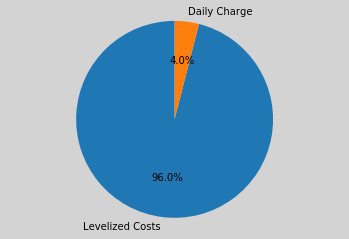

Total roof area of the  building: 599 m²
Total roof area used 586 m²
Percentage: 97.9%
[[145, 245, 125, 6, 11, 46, 0.5499999999999999, 0.6499999999999999, 0.7499999999999998, 3334.88, 322.368, 322.368, 0.0, 0.0, {'Levelized Costs': 3201.821, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60118844013, 61845.7, 586.124]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 150, 210, 1, 31, 11, 0.35, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 1.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1591906547546387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.414797782897949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4516732692718506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 320.487, 0.0]


ERROR:ga_logger:Cost: 3316.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,316 per year


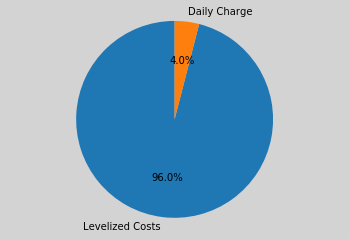

Total roof area of the  building: 599 m²
Total roof area used 427 m²
Percentage: 71.4%
[[250, 150, 210, 1, 31, 11, 0.35, 0.7499999999999998, 0.8999999999999999, 3316.2, 320.487, 0.0, 320.487, 0.0, {'Levelized Costs': 3183.148, 'Energy Charge': 0.009999999999877218, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60097188989, 61845.7, 427.316]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 90, 245, 6, 41, 16, 0.2, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1125547885894775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3788912296295166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.369058847427368 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [46.9444, 0.0, 291.232]


ERROR:ga_logger:Cost: 3491.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,492 per year


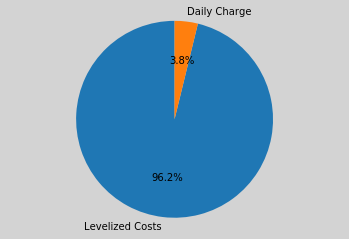

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 90, 245, 6, 41, 16, 0.2, 0.6499999999999999, 0.7999999999999998, 3491.89, 338.17640000000006, 46.9444, 0.0, 291.232, {'Levelized Costs': 3358.824, 'Energy Charge': 0.024000000000114596, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60137000726, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 125, 220, 21, 1, 31, 0.35, 0.2, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8387439250946045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5027315616607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.344844102859497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [125.704, 0.0, 203.665]


ERROR:ga_logger:Cost: 3404.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,404 per year


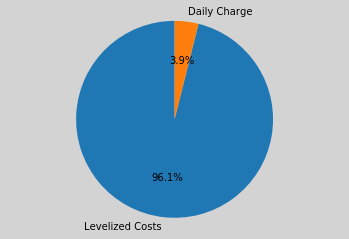

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[225, 125, 220, 21, 1, 31, 0.35, 0.2, 0.8499999999999999, 3404.42, 329.36899999999997, 125.704, 0.0, 203.665, {'Levelized Costs': 3271.375, 'Energy Charge': 0.0030000000000995897, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60193154493, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 255, 130, 21, 41, 41, 0.44999999999999996, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1055238246917725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.498243808746338 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3941502571105957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [219.225, 0.0, 100.435]


ERROR:ga_logger:Cost: 3307.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


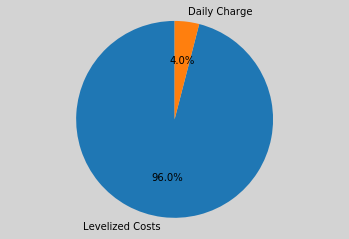

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 255, 130, 21, 41, 41, 0.44999999999999996, 0.5499999999999999, 0.8999999999999999, 3307.99, 319.65999999999997, 219.225, 0.0, 100.435, {'Levelized Costs': 3174.9369999999994, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599576309934, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 260, 115, 46, 16, 51, 0.5999999999999999, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.116036653518677 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3807075023651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3940908908843994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [308.209, 0.0, 0.0]


ERROR:ga_logger:Cost: 3194.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,194 per year


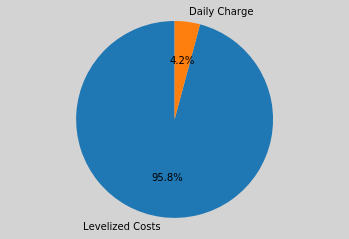

Total roof area of the  building: 599 m²
Total roof area used 514 m²
Percentage: 85.8%
[[185, 260, 115, 46, 16, 51, 0.5999999999999999, 0.44999999999999996, 0.7499999999999998, 3194.25, 308.209, 308.209, 0.0, 0.0, {'Levelized Costs': 3061.1969999999997, 'Energy Charge': 0.011000000000251475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60213570607, 61845.7, 513.682]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 170, 145, 36, 21, 46, 0.8499999999999999, 0.39999999999999997, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.176734209060669 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3683652877807617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3802664279937744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 131.727, 188.612]


ERROR:ga_logger:Cost: 3314.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


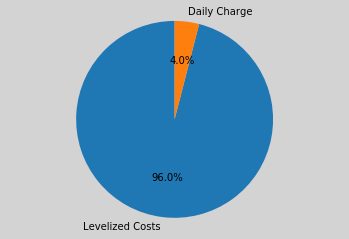

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[250, 170, 145, 36, 21, 46, 0.8499999999999999, 0.39999999999999997, 0.7, 3314.72, 320.339, 0.0, 131.727, 188.612, {'Levelized Costs': 3181.6659999999997, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60234756995, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 215, 215, 1, 16, 51, 0.39999999999999997, 0.7499999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.276283025741577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5047671794891357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.432166337966919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 318.237, 0.0]


ERROR:ga_logger:Cost: 3293.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,294 per year


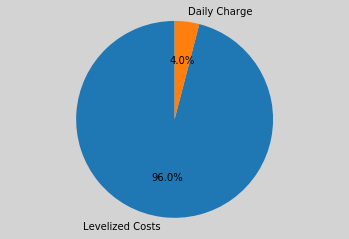

Total roof area of the  building: 599 m²
Total roof area used 424 m²
Percentage: 70.9%
[[220, 215, 215, 1, 16, 51, 0.39999999999999997, 0.7499999999999998, 0.44999999999999996, 3293.85, 318.237, 0.0, 318.237, 0.0, {'Levelized Costs': 3160.7949999999996, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601768929584, 61845.7, 424.316]]


ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 130, 115, 16, 56, 11, 0.39999999999999997, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.356622219085693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4888737201690674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4836585521698 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [147.822, 0.0, 171.906]


ERROR:ga_logger:Cost: 3308.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,309 per year


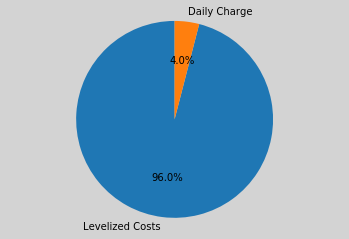

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 130, 115, 16, 56, 11, 0.39999999999999997, 0.5499999999999999, 0.7499999999999998, 3308.65, 319.728, 147.822, 0.0, 171.906, {'Levelized Costs': 3175.599, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60169830013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 195, 255, 26, 56, 46, 0.3, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.223450660705566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4885387420654297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4158384799957275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [33.301, 292.655, 0.0]


ERROR:ga_logger:Cost: 3370.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,371 per year


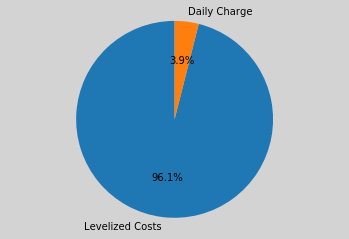

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 195, 255, 26, 56, 46, 0.3, 0.5999999999999999, 0.39999999999999997, 3370.52, 325.95599999999996, 33.301, 292.655, 0.0, {'Levelized Costs': 3237.466, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162503912, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 175, 205, 31, 16, 21, 0.35, 0.44999999999999996, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.133748769760132 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3078835010528564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9051780700683594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 3663.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0138 /kWh
Total Cost of the system: $ 3,663 per year


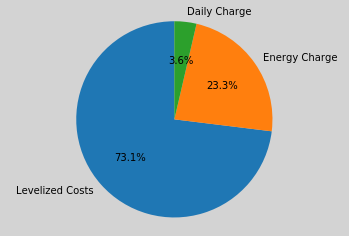

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[190, 175, 205, 31, 16, 21, 0.35, 0.44999999999999996, 0.2, 3663.26, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.156, 'Energy Charge': 854.0620000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55029.60650024501, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 150, 150, 36, 11, 46, 0.8499999999999999, 0.35, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.218547344207764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.335999011993408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.467693567276001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [189.874, 0.0, 131.383]


ERROR:ga_logger:Cost: 3323.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,324 per year


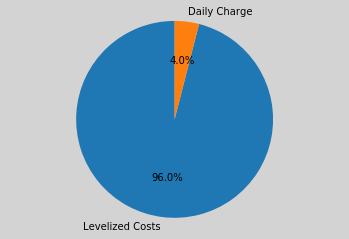

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 150, 150, 36, 11, 46, 0.8499999999999999, 0.35, 0.35, 3323.85, 321.257, 189.874, 0.0, 131.383, {'Levelized Costs': 3190.794, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60062628003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 185, 105, 46, 26, 11, 0.25, 0.6499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.237428903579712 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4385437965393066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4459774494171143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [55.4266, 245.086, 0.0]


ERROR:ga_logger:Cost: 3117.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,118 per year


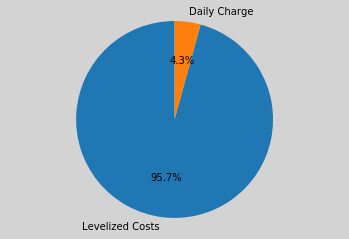

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 185, 105, 46, 26, 11, 0.25, 0.6499999999999999, 0.25, 3117.81, 300.5126, 55.4266, 245.086, 0.0, {'Levelized Costs': 2984.75, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6014902152, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 265, 235, 21, 56, 1, 0.5499999999999999, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.196514129638672 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3733043670654297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4745352268218994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.776]


ERROR:ga_logger:Cost: 3458.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,458 per year


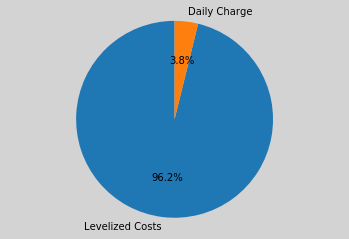

Total roof area of the  building: 599 m²
Total roof area used 394 m²
Percentage: 65.8%
[[90, 265, 235, 21, 56, 1, 0.5499999999999999, 0.39999999999999997, 0.8499999999999999, 3458.12, 334.776, 0.0, 0.0, 334.776, {'Levelized Costs': 3325.0669999999996, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59877154124, 61845.7, 393.854]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 115, 200, 56, 26, 11, 0.5999999999999999, 0.49999999999999994, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.242363691329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.347329616546631 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4543468952178955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [293.041, 0.0, 38.6261]


ERROR:ga_logger:Cost: 3427.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,427 per year


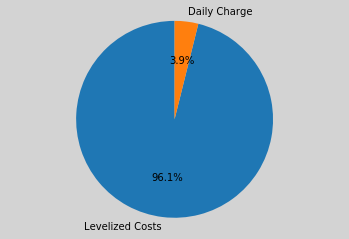

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[160, 115, 200, 56, 26, 11, 0.5999999999999999, 0.49999999999999994, 0.35, 3427.24, 331.6671, 293.041, 0.0, 38.6261, {'Levelized Costs': 3294.1879999999996, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60016464126, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 250, 235, 16, 36, 16, 0.49999999999999994, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.355096340179443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3729746341705322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4900479316711426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [287.683, 0.0, 18.7171]


ERROR:ga_logger:Cost: 3176.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,176 per year


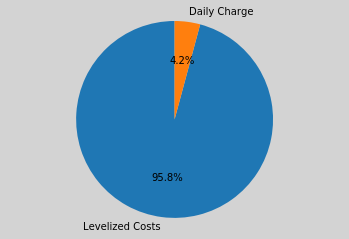

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 250, 235, 16, 36, 16, 0.49999999999999994, 0.8999999999999999, 0.7999999999999998, 3176.28, 306.4001, 287.683, 0.0, 18.7171, {'Levelized Costs': 3043.235, 'Energy Charge': 0.0030000000003269633, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60166248367, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 155, 160, 41, 31, 1, 0.2, 0.25, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.478760242462158 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.35953426361084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5403199195861816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 51.52, 274.877]


ERROR:ga_logger:Cost: 3374.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


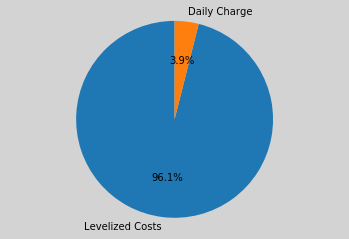

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[250, 155, 160, 41, 31, 1, 0.2, 0.25, 0.7, 3374.9, 326.397, 0.0, 51.52, 274.877, {'Levelized Costs': 3241.842, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60072371711, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 120, 135, 16, 16, 46, 0.44999999999999996, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4283764362335205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.399782180786133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3826096057891846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 338.957, 0.0]


ERROR:ga_logger:Cost: 3499.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,500 per year


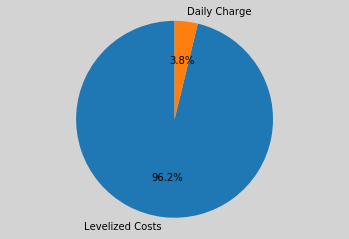

Total roof area of the  building: 599 m²
Total roof area used 399 m²
Percentage: 66.6%
[[265, 120, 135, 16, 16, 46, 0.44999999999999996, 0.8499999999999999, 0.5999999999999999, 3499.65, 338.957, 0.0, 338.957, 0.0, {'Levelized Costs': 3366.6069999999995, 'Energy Charge': 0.0010000000005447873, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60433402018, 61845.7, 398.773]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 245, 100, 1, 46, 51, 0.35, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.384946584701538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.375488042831421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4013640880584717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 329.319, 0.0]


ERROR:ga_logger:Cost: 4230.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0134 /kWh
Total Cost of the system: $ 4,231 per year


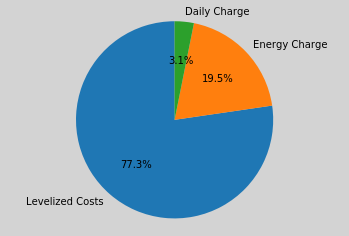

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 245, 100, 1, 46, 51, 0.35, 0.5499999999999999, 0.7499999999999998, 4230.99, 329.319, 0.0, 329.319, 0.0, {'Levelized Costs': 3270.8639999999996, 'Energy Charge': 827.0840000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55244.85005560409, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 95, 175, 6, 46, 21, 0.6499999999999999, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.332932472229004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4190070629119873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4192006587982178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.023]


ERROR:ga_logger:Cost: 3222.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


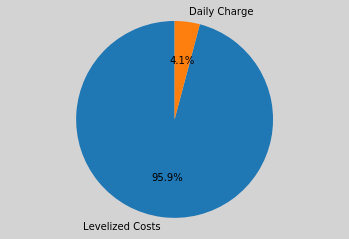

Total roof area of the  building: 599 m²
Total roof area used 389 m²
Percentage: 64.9%
[[140, 95, 175, 6, 46, 21, 0.6499999999999999, 0.39999999999999997, 0.7999999999999998, 3222.2, 311.023, 0.0, 0.0, 311.023, {'Levelized Costs': 3089.144, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60148999492, 61845.7, 388.779]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 170, 90, 11, 21, 16, 0.49999999999999994, 0.8999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2907023429870605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3550899028778076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339609384536743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 321.006, 0.0]


ERROR:ga_logger:Cost: 3321.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,321 per year


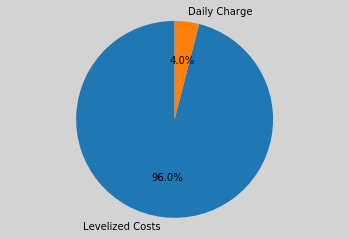

Total roof area of the  building: 599 m²
Total roof area used 357 m²
Percentage: 59.6%
[[100, 170, 90, 11, 21, 16, 0.49999999999999994, 0.8999999999999999, 0.8499999999999999, 3321.35, 321.006, 0.0, 321.006, 0.0, {'Levelized Costs': 3188.301, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60408079018, 61845.7, 356.673]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 225, 260, 31, 26, 6, 0.5999999999999999, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.425029516220093 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.357922077178955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6746819019317627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [326.341, 10.9718, 0.0]


ERROR:ga_logger:Cost: 3483.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,483 per year


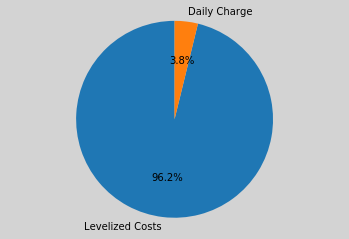

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 225, 260, 31, 26, 6, 0.5999999999999999, 0.2, 0.44999999999999996, 3483.32, 337.3128, 326.341, 10.9718, 0.0, {'Levelized Costs': 3350.261, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59915149813, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 185, 175, 16, 1, 16, 0.3, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.352727651596069 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3866872787475586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3469767570495605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.805]


ERROR:ga_logger:Cost: 3269.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,270 per year


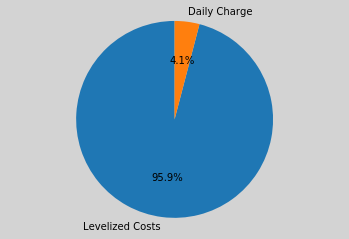

Total roof area of the  building: 599 m²
Total roof area used 372 m²
Percentage: 62.1%
[[235, 185, 175, 16, 1, 16, 0.3, 0.6499999999999999, 0.8499999999999999, 3269.69, 315.805, 0.0, 0.0, 315.805, {'Levelized Costs': 3136.6259999999997, 'Energy Charge': 0.022000000000218733, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6019698693, 61845.7, 371.535]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 140, 185, 46, 41, 31, 0.7499999999999998, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.485184192657471 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4646828174591064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429422616958618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.442]


ERROR:ga_logger:Cost: 3266.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,266 per year


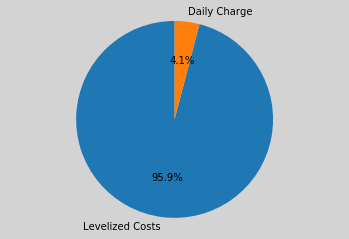

Total roof area of the  building: 599 m²
Total roof area used 371 m²
Percentage: 62.0%
[[220, 140, 185, 46, 41, 31, 0.7499999999999998, 0.7999999999999998, 0.8499999999999999, 3266.09, 315.442, 0.0, 0.0, 315.442, {'Levelized Costs': 3133.0280000000002, 'Energy Charge': 0.020000000000095497, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59814144764, 61845.7, 371.109]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 250, 115, 11, 6, 6, 0.6499999999999999, 0.25, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3988707065582275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.405271291732788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3946280479431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [320.806, 0.0, 0.0]


ERROR:ga_logger:Cost: 3319.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


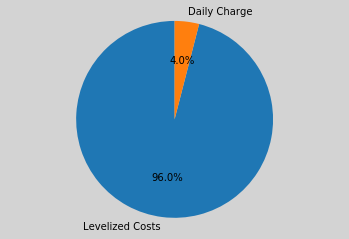

Total roof area of the  building: 599 m²
Total roof area used 494 m²
Percentage: 82.4%
[[130, 250, 115, 11, 6, 6, 0.6499999999999999, 0.25, 0.44999999999999996, 3319.36, 320.806, 320.806, 0.0, 0.0, {'Levelized Costs': 3186.3070000000002, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60261825186, 61845.7, 493.547]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 255, 120, 46, 26, 16, 0.5499999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.380709409713745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3963069915771484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3601999282836914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [308.685, 0.0, 0.0]


ERROR:ga_logger:Cost: 3198.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


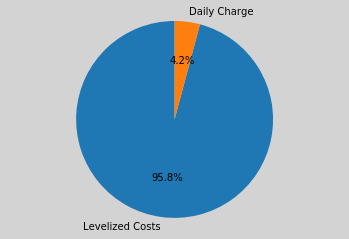

Total roof area of the  building: 599 m²
Total roof area used 561 m²
Percentage: 93.7%
[[170, 255, 120, 46, 26, 16, 0.5499999999999999, 0.3, 0.7499999999999998, 3198.97, 308.685, 308.685, 0.0, 0.0, {'Levelized Costs': 3065.917, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601897900066, 61845.7, 561.245]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 105, 110, 26, 6, 1, 0.8999999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.436941385269165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3268985748291016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.511467695236206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [7.95414, 324.458, 0.0]


ERROR:ga_logger:Cost: 3434.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,435 per year


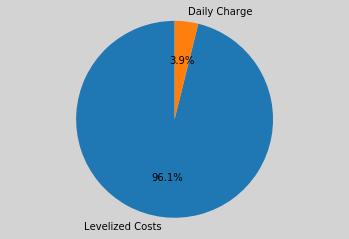

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 105, 110, 26, 6, 1, 0.8999999999999999, 0.5499999999999999, 0.5499999999999999, 3434.64, 332.41214, 7.95414, 324.458, 0.0, {'Levelized Costs': 3301.582, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60088648672, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 265, 185, 56, 11, 1, 0.8499999999999999, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.391894102096558 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.388400077819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5054357051849365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [88.455, 0.0, 247.348]


ERROR:ga_logger:Cost: 3468.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,468 per year


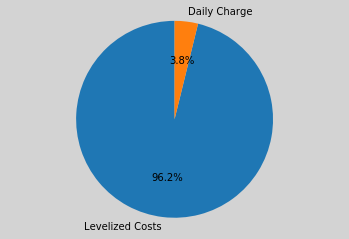

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 265, 185, 56, 11, 1, 0.8499999999999999, 0.8999999999999999, 0.49999999999999994, 3468.32, 335.803, 88.455, 0.0, 247.348, {'Levelized Costs': 3335.268, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6016662846, 61845.7, 598.762]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 180, 175, 11, 21, 1, 0.25, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.426893949508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3854668140411377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4994113445281982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 310.433, 0.0]


ERROR:ga_logger:Cost: 3216.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,216 per year


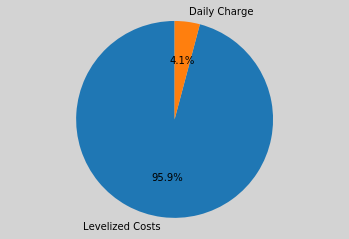

Total roof area of the  building: 599 m²
Total roof area used 388 m²
Percentage: 64.8%
[[125, 180, 175, 11, 21, 1, 0.25, 0.7999999999999998, 0.6499999999999999, 3216.34, 310.433, 0.0, 310.433, 0.0, {'Levelized Costs': 3083.2850000000003, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600398438, 61845.7, 388.041]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 100, 135, 21, 26, 56, 0.49999999999999994, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.462128400802612 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3339731693267822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4546165466308594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [283.145, 29.2251, 0.0]


ERROR:ga_logger:Cost: 3235.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,236 per year


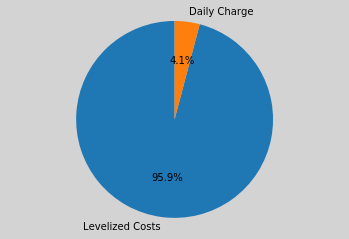

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 100, 135, 21, 26, 56, 0.49999999999999994, 0.8999999999999999, 0.6499999999999999, 3235.58, 312.3701, 283.145, 29.2251, 0.0, {'Levelized Costs': 3102.517, 'Energy Charge': 0.021000000000015007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60147701012, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 130, 240, 11, 16, 46, 0.39999999999999997, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 11.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.5275139808654785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502819538116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.536548614501953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [133.028, 186.334, 0.0]


ERROR:ga_logger:Cost: 3305.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,305 per year


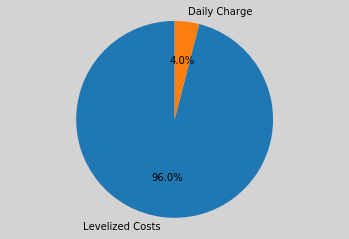

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 130, 240, 11, 16, 46, 0.39999999999999997, 0.7, 0.7499999999999998, 3305.02, 319.36199999999997, 133.028, 186.334, 0.0, {'Levelized Costs': 3171.9689999999996, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60096109198, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 250, 265, 11, 41, 56, 0.5999999999999999, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.687657117843628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454007625579834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4488048553466797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [339.197, 0.0, 0.0]


ERROR:ga_logger:Cost: 3502.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,502 per year


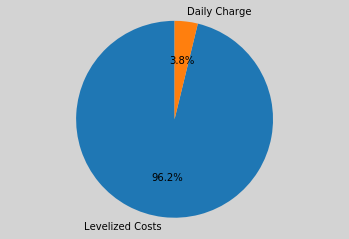

Total roof area of the  building: 599 m²
Total roof area used 565 m²
Percentage: 94.4%
[[90, 250, 265, 11, 41, 56, 0.5999999999999999, 0.5999999999999999, 0.39999999999999997, 3502.03, 339.197, 339.197, 0.0, 0.0, {'Levelized Costs': 3368.977, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602076969924, 61845.7, 565.328]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 210, 180, 36, 16, 51, 0.7499999999999998, 0.44999999999999996, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.522534370422363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3741331100463867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.472147226333618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [204.653, 146.651, 0.0]


ERROR:ga_logger:Cost: 3622.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,622 per year


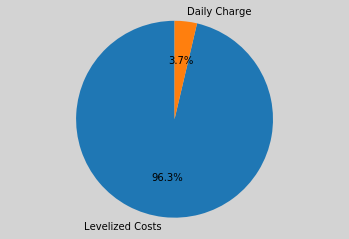

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 210, 180, 36, 16, 51, 0.7499999999999998, 0.44999999999999996, 0.2, 3622.28, 351.304, 204.653, 146.651, 0.0, {'Levelized Costs': 3489.214, 'Energy Charge': 0.02400000000034197, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105846219, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 175, 250, 31, 41, 21, 0.8499999999999999, 0.3, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.594668626785278 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4236581325531006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.066777229309082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 64.885, 267.735]


ERROR:ga_logger:Cost: 3436.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 44,230 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,437 per year


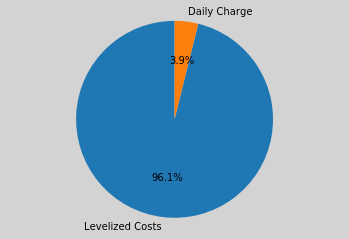

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 175, 250, 31, 41, 21, 0.8499999999999999, 0.3, 0.7, 3436.7, 332.62, 0.0, 64.885, 267.735, {'Levelized Costs': 3303.6478, 'Energy Charge': 0.010199999999827014, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601685883354, 44229.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 90, 230, 31, 26, 11, 0.35, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.572757959365845 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3934643268585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4472577571868896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 301.302, 60.8492]


ERROR:ga_logger:Cost: 3730.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,730 per year


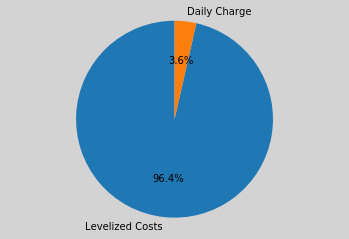

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 90, 230, 31, 26, 11, 0.35, 0.6499999999999999, 0.44999999999999996, 3730.01, 362.1512, 0.0, 301.302, 60.8492, {'Levelized Costs': 3596.957, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60169370022, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 185, 250, 16, 11, 21, 0.6499999999999999, 0.49999999999999994, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.699218511581421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8217990398406982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.08669900894165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [310.176, 0.0, 0.0]


ERROR:ga_logger:Cost: 3213.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


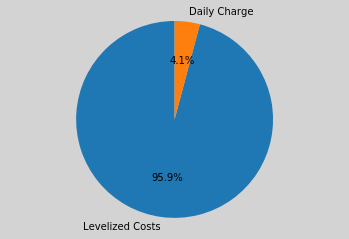

Total roof area of the  building: 599 m²
Total roof area used 477 m²
Percentage: 79.7%
[[205, 185, 250, 16, 11, 21, 0.6499999999999999, 0.49999999999999994, 0.7, 3213.78, 310.176, 310.176, 0.0, 0.0, {'Levelized Costs': 3080.7270000000003, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60074034036, 61845.7, 477.194]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 125, 195, 11, 46, 36, 0.7, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.909786224365234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4220104217529297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.461956024169922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.817]


ERROR:ga_logger:Cost: 3150.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,151 per year


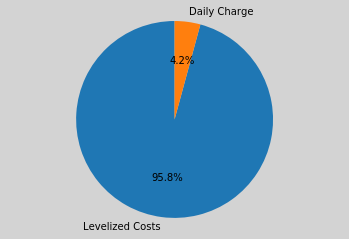

Total roof area of the  building: 599 m²
Total roof area used 506 m²
Percentage: 84.6%
[[200, 125, 195, 11, 46, 36, 0.7, 0.25, 0.5999999999999999, 3150.63, 303.817, 0.0, 0.0, 303.817, {'Levelized Costs': 3017.574, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60087099986, 61845.7, 506.362]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 120, 170, 31, 16, 21, 0.8499999999999999, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.625811338424683 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6857848167419434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.555083990097046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.7]


ERROR:ga_logger:Cost: 3129.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,130 per year


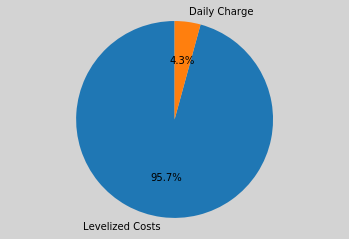

Total roof area of the  building: 599 m²
Total roof area used 503 m²
Percentage: 84.0%
[[185, 120, 170, 31, 16, 21, 0.8499999999999999, 0.8999999999999999, 0.5999999999999999, 3129.6, 301.7, 0.0, 0.0, 301.7, {'Levelized Costs': 2996.545, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60252029176, 61845.7, 502.833]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 185, 250, 56, 26, 26, 0.5499999999999999, 0.3, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.827213764190674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.507783889770508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486266613006592 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 179.629, 0.0]


ERROR:ga_logger:Cost: 4913.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0484 /kWh
Total Cost of the system: $ 4,913 per year


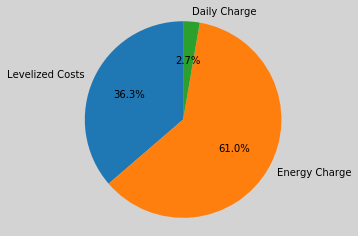

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 185, 250, 56, 26, 26, 0.5499999999999999, 0.3, 0.2, 4913.05, 179.629, 0.0, 179.629, 0.0, {'Levelized Costs': 1784.1110000000003, 'Energy Charge': 2995.897, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 37935.9221302286, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 120, 125, 36, 16, 21, 0.25, 0.7999999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.666411399841309 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4172322750091553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5450143814086914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 331.544]


ERROR:ga_logger:Cost: 3426.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,426 per year


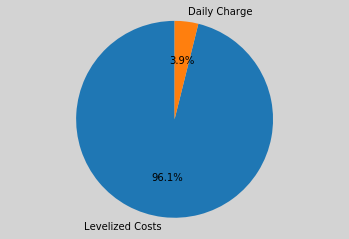

Total roof area of the  building: 599 m²
Total roof area used 442 m²
Percentage: 73.8%
[[100, 120, 125, 36, 16, 21, 0.25, 0.7999999999999998, 0.7499999999999998, 3426.02, 331.544, 0.0, 0.0, 331.544, {'Levelized Costs': 3292.9629999999997, 'Energy Charge': 0.015000000000441105, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60091962997, 61845.7, 442.059]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 145, 160, 6, 21, 56, 0.6499999999999999, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.585670232772827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389549732208252 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4196646213531494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s

ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [266.839, 0.0, 56.472]


ERROR:ga_logger:Cost: 3344.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,344 per year


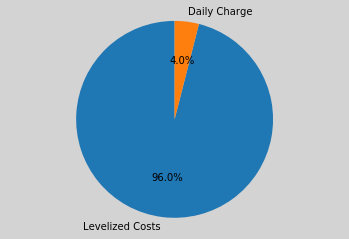

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 145, 160, 6, 21, 56, 0.6499999999999999, 0.8999999999999999, 0.3, 3344.25, 323.311, 266.839, 0.0, 56.472, {'Levelized Costs': 3211.19, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60424183999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 255, 135, 46, 31, 46, 0.7499999999999998, 0.3, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8042380809783936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4979331493377686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4620072841644287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [270.783, 0.0, 59.4295]


ERROR:ga_logger:Cost: 3412.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,413 per year


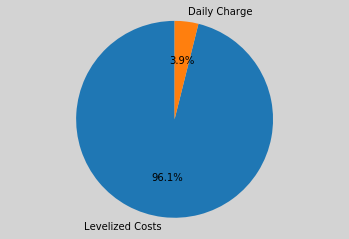

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 255, 135, 46, 31, 46, 0.7499999999999998, 0.3, 0.25, 3412.79, 330.21250000000003, 270.783, 0.0, 59.4295, {'Levelized Costs': 3279.7329999999997, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60121253988, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 205, 220, 41, 26, 46, 0.49999999999999994, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.804904460906982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5681233406066895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5107386112213135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [298.43, 0.0, 0.0]


ERROR:ga_logger:Cost: 3097.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,097 per year


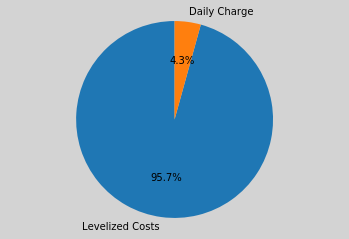

Total roof area of the  building: 599 m²
Total roof area used 597 m²
Percentage: 99.7%
[[185, 205, 220, 41, 26, 46, 0.49999999999999994, 0.6499999999999999, 0.7999999999999998, 3097.12, 298.43, 298.43, 0.0, 0.0, {'Levelized Costs': 2964.064, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60010729027, 61845.7, 596.859]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 120, 110, 56, 1, 56, 0.8999999999999999, 0.39999999999999997, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.820919036865234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5131304264068604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4784085750579834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [184.279, 157.603, 0.0]


ERROR:ga_logger:Cost: 3528.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,529 per year


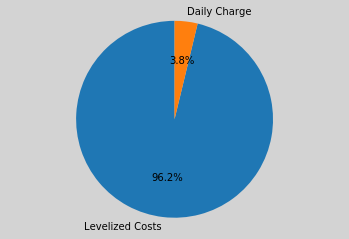

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[180, 120, 110, 56, 1, 56, 0.8999999999999999, 0.39999999999999997, 0.8999999999999999, 3528.69, 341.882, 184.279, 157.603, 0.0, {'Levelized Costs': 3395.6349999999998, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60236362402, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 140, 120, 16, 16, 56, 0.3, 0.35, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.839599370956421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.473644256591797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.442986011505127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 209.567, 0.0]


ERROR:ga_logger:Cost: 4703.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0402 /kWh
Total Cost of the system: $ 4,704 per year


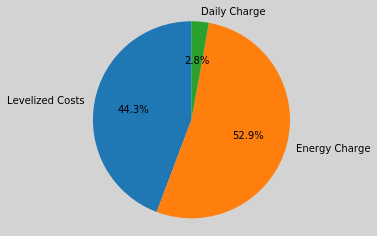

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 140, 120, 16, 16, 56, 0.3, 0.35, 0.25, 4703.55, 209.567, 0.0, 209.567, 0.0, {'Levelized Costs': 2081.4560000000006, 'Energy Charge': 2489.0519999999997, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 41980.96207971215, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 235, 240, 6, 41, 6, 0.2, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.725728273391724 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.569950580596924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5278780460357666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 58.9353, 273.677]


ERROR:ga_logger:Cost: 3436.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,437 per year


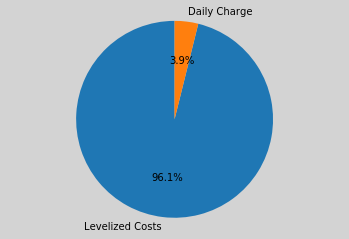

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 235, 240, 6, 41, 6, 0.2, 0.2, 0.8999999999999999, 3436.63, 332.6123, 0.0, 58.9353, 273.677, {'Levelized Costs': 3303.572, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60358614494, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 180, 100, 46, 21, 41, 0.7499999999999998, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.884272813796997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.443401575088501 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5546393394470215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 314.308, 0.0]


ERROR:ga_logger:Cost: 3254.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,255 per year


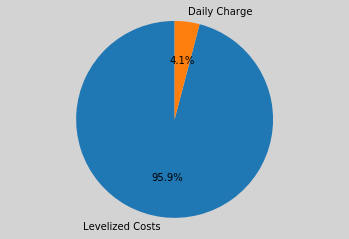

Total roof area of the  building: 599 m²
Total roof area used 370 m²
Percentage: 61.8%
[[250, 180, 100, 46, 21, 41, 0.7499999999999998, 0.8499999999999999, 0.49999999999999994, 3254.82, 314.308, 0.0, 314.308, 0.0, {'Levelized Costs': 3121.761, 'Energy Charge': 0.017000000000336968, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60073732863, 61845.7, 369.774]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 100, 235, 6, 21, 6, 0.5499999999999999, 0.5999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.733830451965332 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.453801155090332 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7979354858398438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [321.176, 0.0, 0.0]


ERROR:ga_logger:Cost: 3323.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,323 per year


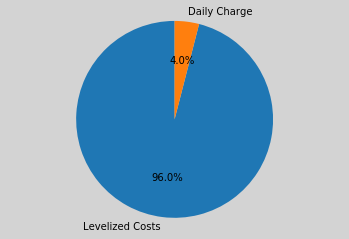

Total roof area of the  building: 599 m²
Total roof area used 584 m²
Percentage: 97.5%
[[195, 100, 235, 6, 21, 6, 0.5499999999999999, 0.5999999999999999, 0.6499999999999999, 3323.04, 321.176, 321.176, 0.0, 0.0, {'Levelized Costs': 3189.977, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5996289946, 61845.7, 583.956]]


ERROR:optimizer_logger:120


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 110, 115, 16, 36, 1, 0.35, 0.7499999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 16.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.814531326293945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5202133655548096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5005176067352295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 226.693, 133.427]


ERROR:ga_logger:Cost: 3709.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,710 per year


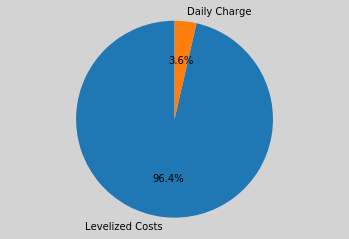

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 110, 115, 16, 36, 1, 0.35, 0.7499999999999998, 0.44999999999999996, 3709.84, 360.12, 0.0, 226.693, 133.427, {'Levelized Costs': 3576.785, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600925390114, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 145, 100, 21, 31, 21, 0.7, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.794719219207764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4669957160949707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5728566646575928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [97.7265, 206.619, 0.0]


ERROR:ga_logger:Cost: 3155.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,156 per year


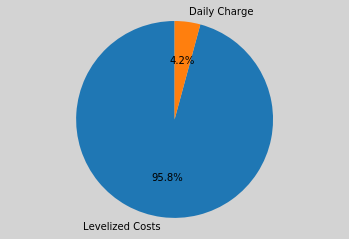

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 145, 100, 21, 31, 21, 0.7, 0.44999999999999996, 0.35, 3155.87, 304.3455, 97.7265, 206.619, 0.0, {'Levelized Costs': 3022.814, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60001066394, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 90, 230, 56, 11, 46, 0.3, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8093767166137695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.425248622894287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.553987741470337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [84.6813, 253.193, 0.0]


ERROR:ga_logger:Cost: 3488.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,489 per year


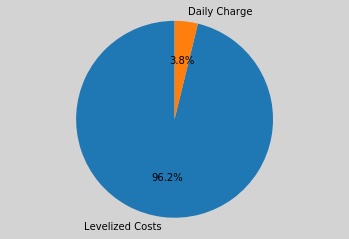

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 90, 230, 56, 11, 46, 0.3, 0.7999999999999998, 0.8499999999999999, 3488.89, 337.8743, 84.6813, 253.193, 0.0, {'Levelized Costs': 3355.8469999999993, 'Energy Charge': 0.0010000000004311005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60059556006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 210, 95, 16, 46, 56, 0.8499999999999999, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.770320892333984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3443684577941895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.463935613632202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [322.204, 0.0, 0.0]


ERROR:ga_logger:Cost: 3333.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,333 per year


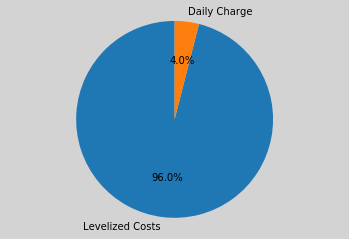

Total roof area of the  building: 599 m²
Total roof area used 379 m²
Percentage: 63.3%
[[150, 210, 95, 16, 46, 56, 0.8499999999999999, 0.7999999999999998, 0.49999999999999994, 3333.25, 322.204, 322.204, 0.0, 0.0, {'Levelized Costs': 3200.2009999999996, 'Energy Charge': 0.007000000000346063, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600813253244, 61845.7, 379.064]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 205, 120, 56, 56, 36, 0.7499999999999998, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.911385774612427 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4424707889556885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4747941493988037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 47.3798, 325.676]


ERROR:ga_logger:Cost: 3838.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,838 per year


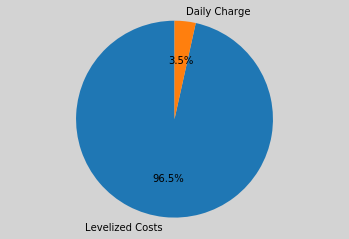

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 205, 120, 56, 56, 36, 0.7499999999999998, 0.2, 0.8999999999999999, 3838.32, 373.0558, 0.0, 47.3798, 325.676, {'Levelized Costs': 3705.259, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6028785501, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 120, 110, 26, 56, 21, 0.5999999999999999, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.889397621154785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4366931915283203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.440924644470215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [301.271, 0.0, 0.0]


ERROR:ga_logger:Cost: 3125.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,125 per year


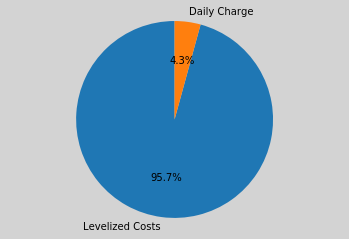

Total roof area of the  building: 599 m²
Total roof area used 502 m²
Percentage: 83.9%
[[195, 120, 110, 26, 56, 21, 0.5999999999999999, 0.7999999999999998, 0.35, 3125.34, 301.271, 301.271, 0.0, 0.0, {'Levelized Costs': 2992.278, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600821968896, 61845.7, 502.119]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 115, 145, 26, 21, 11, 0.25, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.850583076477051 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471687078475952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4599289894104004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [48.1737, 0.0, 263.944]


ERROR:ga_logger:Cost: 3233.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,233 per year


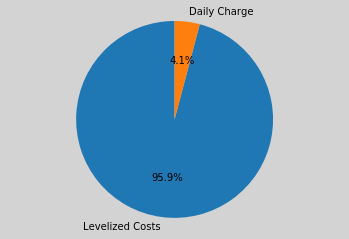

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[180, 115, 145, 26, 21, 11, 0.25, 0.49999999999999994, 0.6499999999999999, 3233.07, 312.1177, 48.1737, 0.0, 263.944, {'Levelized Costs': 3100.0119999999997, 'Energy Charge': 0.0160000000004743, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60215584014, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 200, 205, 46, 56, 31, 0.8999999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.845346689224243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4030277729034424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4726195335388184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.347]


ERROR:ga_logger:Cost: 3245.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


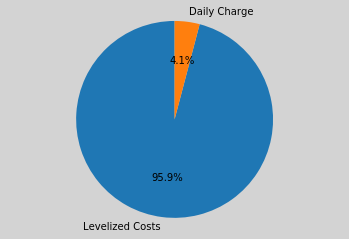

Total roof area of the  building: 599 m²
Total roof area used 448 m²
Percentage: 74.8%
[[160, 200, 205, 46, 56, 31, 0.8999999999999999, 0.8999999999999999, 0.7, 3245.28, 313.347, 0.0, 0.0, 313.347, {'Levelized Costs': 3112.227, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59936955436, 61845.7, 447.638]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 160, 205, 51, 6, 11, 0.5499999999999999, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.861100196838379 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368600606918335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5202043056488037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [312.022, 0.0, 0.0]


ERROR:ga_logger:Cost: 3232.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


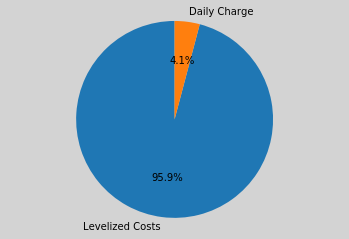

Total roof area of the  building: 599 m²
Total roof area used 567 m²
Percentage: 94.7%
[[185, 160, 205, 51, 6, 11, 0.5499999999999999, 0.7499999999999998, 0.5999999999999999, 3232.12, 312.022, 312.022, 0.0, 0.0, {'Levelized Costs': 3099.069, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60178534297, 61845.7, 567.312]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 100, 135, 6, 56, 41, 0.7999999999999998, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.0137529373168945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5129482746124268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4813811779022217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [160.342, 0.0, 159.333]


ERROR:ga_logger:Cost: 3308.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


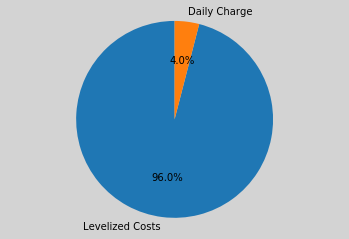

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[205, 100, 135, 6, 56, 41, 0.7999999999999998, 0.25, 0.39999999999999997, 3308.14, 319.675, 160.342, 0.0, 159.333, {'Levelized Costs': 3175.084, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60297522902, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 135, 125, 11, 31, 46, 0.7999999999999998, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.898507356643677 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4780609607696533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.510035991668701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 319.846, 0.0]


ERROR:ga_logger:Cost: 3309.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,310 per year


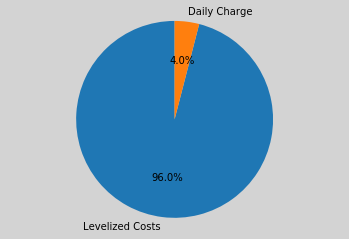

Total roof area of the  building: 599 m²
Total roof area used 533 m²
Percentage: 89.0%
[[105, 135, 125, 11, 31, 46, 0.7999999999999998, 0.5999999999999999, 0.2, 3309.83, 319.846, 0.0, 319.846, 0.0, {'Levelized Costs': 3176.7699999999995, 'Energy Charge': 0.01800000000048385, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60133066186, 61845.7, 533.077]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 220, 170, 31, 11, 31, 0.5499999999999999, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.9193243980407715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5584096908569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4392454624176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 144s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.387]


ERROR:ga_logger:Cost: 3146.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,146 per year


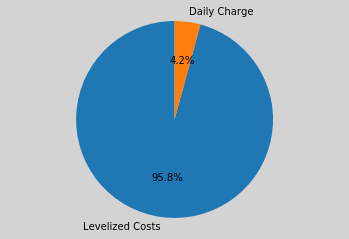

Total roof area of the  building: 599 m²
Total roof area used 467 m²
Percentage: 78.0%
[[150, 220, 170, 31, 11, 31, 0.5499999999999999, 0.35, 0.6499999999999999, 3146.35, 303.387, 0.0, 0.0, 303.387, {'Levelized Costs': 3013.294, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60091608981, 61845.7, 466.749]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 235, 105, 11, 46, 31, 0.7999999999999998, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.038152456283569 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4856152534484863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.639549970626831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [283.249, 0.0, 48.94]


ERROR:ga_logger:Cost: 3432.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,432 per year


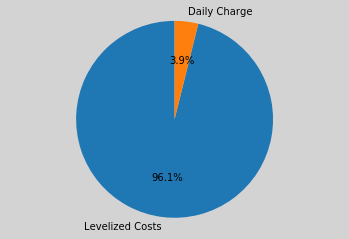

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 235, 105, 11, 46, 31, 0.7999999999999998, 0.8999999999999999, 0.2, 3432.43, 332.189, 283.249, 0.0, 48.94, {'Levelized Costs': 3299.3649999999993, 'Energy Charge': 0.023000000000365617, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60171772015, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 130, 260, 16, 11, 11, 0.8999999999999999, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.3263633251190186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5006206035614014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.536576986312866 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [331.993, 0.0, 0.0]


ERROR:ga_logger:Cost: 3430.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,430 per year


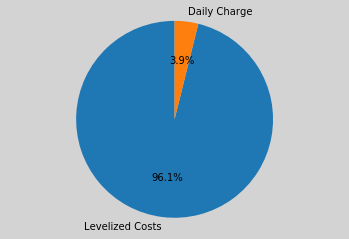

Total roof area of the  building: 599 m²
Total roof area used 369 m²
Percentage: 61.6%
[[140, 130, 260, 16, 11, 11, 0.8999999999999999, 0.8999999999999999, 0.8999999999999999, 3430.48, 331.993, 331.993, 0.0, 0.0, {'Levelized Costs': 3297.422, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601076899955, 61845.7, 368.881]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 230, 160, 46, 11, 56, 0.8999999999999999, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.967367649078369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6647801399230957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429255485534668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 330.519, 0.0]


ERROR:ga_logger:Cost: 3415.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,416 per year


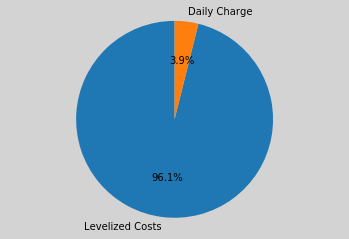

Total roof area of the  building: 599 m²
Total roof area used 389 m²
Percentage: 64.9%
[[215, 230, 160, 46, 11, 56, 0.8999999999999999, 0.8499999999999999, 0.5999999999999999, 3415.84, 330.519, 0.0, 330.519, 0.0, {'Levelized Costs': 3282.784, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60246147705, 61845.7, 388.846]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 200, 265, 16, 6, 46, 0.2, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.330185651779175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4639599323272705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.546407461166382 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [4.44055, 317.107, 0.0]


ERROR:ga_logger:Cost: 3326.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,327 per year


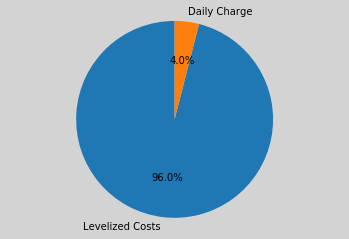

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[215, 200, 265, 16, 6, 46, 0.2, 0.5499999999999999, 0.2, 3326.74, 321.54755, 4.44055, 317.107, 0.0, {'Levelized Costs': 3193.6839999999997, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600332317765, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 245, 235, 36, 56, 21, 0.49999999999999994, 0.2, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.0460426807403564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4670257568359375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.036722898483276 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [299.186, 0.0, 0.0]


ERROR:ga_logger:Cost: 3104.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,105 per year


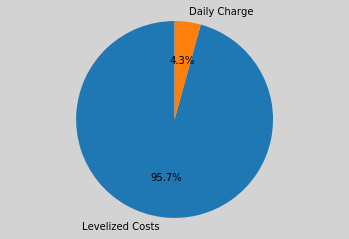

Total roof area of the  building: 599 m²
Total roof area used 598 m²
Percentage: 99.9%
[[165, 245, 235, 36, 56, 21, 0.49999999999999994, 0.2, 0.7499999999999998, 3104.63, 299.186, 299.186, 0.0, 0.0, {'Levelized Costs': 2971.574, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60233429987, 61845.7, 598.371]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 125, 115, 6, 6, 26, 0.6499999999999999, 0.2, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.048156261444092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.451396942138672 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.481119155883789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [293.314, 0.0, 36.8775]


ERROR:ga_logger:Cost: 3412.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,413 per year


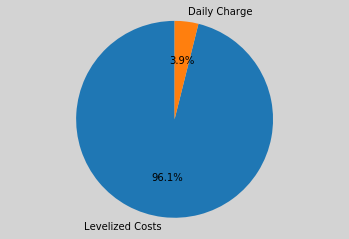

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 125, 115, 6, 6, 26, 0.6499999999999999, 0.2, 0.25, 3412.58, 330.1915, 293.314, 0.0, 36.8775, {'Levelized Costs': 3279.5269999999996, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60285440017, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 155, 95, 46, 56, 46, 0.5499999999999999, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.9786012172698975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.386831283569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4423327445983887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [319.216, 4.5922, 0.0]


ERROR:ga_logger:Cost: 3349.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,349 per year


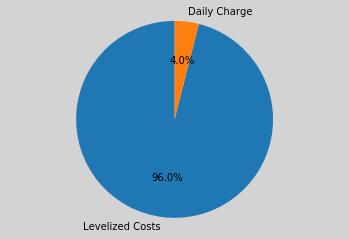

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 155, 95, 46, 56, 46, 0.5499999999999999, 0.25, 0.5999999999999999, 3349.19, 323.8082, 319.216, 4.5922, 0.0, {'Levelized Costs': 3216.135, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60060052997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 170, 240, 26, 51, 16, 0.49999999999999994, 0.25, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.963528871536255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4434421062469482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5056045055389404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [296.06, 0.0, 0.0]


ERROR:ga_logger:Cost: 3073.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,074 per year


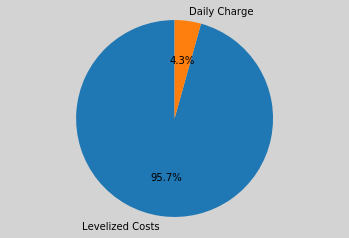

Total roof area of the  building: 599 m²
Total roof area used 592 m²
Percentage: 98.9%
[[180, 170, 240, 26, 51, 16, 0.49999999999999994, 0.25, 0.3, 3073.59, 296.06, 296.06, 0.0, 0.0, {'Levelized Costs': 2940.5350000000003, 'Energy Charge': 0.012999999999806278, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603286000005, 61845.7, 592.121]]


ERROR:optimizer_logger:140


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 90, 235, 31, 56, 36, 0.25, 0.3, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.009204864501953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444175958633423 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4097583293914795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [65.9367, 0.0, 301.513]


ERROR:ga_logger:Cost: 3782.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,783 per year


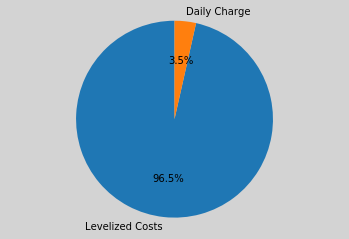

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 90, 235, 31, 56, 36, 0.25, 0.3, 0.8999999999999999, 3782.64, 367.4497, 65.9367, 0.0, 301.513, {'Levelized Costs': 3649.576, 'Energy Charge': 0.022000000000048203, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60238167598, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 235, 105, 21, 56, 21, 0.3, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.662903547286987 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.479687452316284 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.472343683242798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [45.2272, 0.0, 291.203]


ERROR:ga_logger:Cost: 3474.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,475 per year


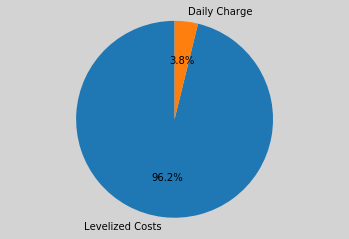

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 235, 105, 21, 56, 21, 0.3, 0.44999999999999996, 0.6499999999999999, 3474.55, 336.43019999999996, 45.2272, 0.0, 291.203, {'Levelized Costs': 3341.4900000000002, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599860230046, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 150, 140, 56, 56, 51, 0.5999999999999999, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.122340440750122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4602880477905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5055654048919678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 65.7596, 302.151]


ERROR:ga_logger:Cost: 3787.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,787 per year


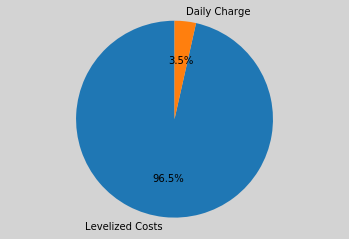

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 150, 140, 56, 56, 51, 0.5999999999999999, 0.25, 0.8999999999999999, 3787.22, 367.91060000000004, 0.0, 65.7596, 302.151, {'Levelized Costs': 3654.1639999999998, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60030280014, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 155, 140, 36, 16, 16, 0.35, 0.2, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.315868854522705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.546365976333618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4529407024383545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [128.539, 0.0, 185.206]


ERROR:ga_logger:Cost: 3249.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


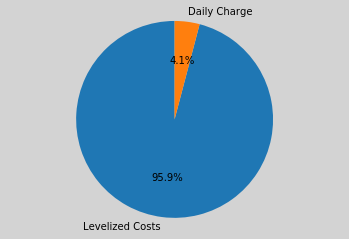

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 155, 140, 36, 16, 16, 0.35, 0.2, 0.7999999999999998, 3249.23, 313.745, 128.539, 0.0, 185.206, {'Levelized Costs': 3116.174, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60150180609, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 170, 150, 51, 21, 56, 0.8999999999999999, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.190357685089111 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.458394765853882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462414264678955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 305.764, 0.0]


ERROR:ga_logger:Cost: 3169.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,170 per year


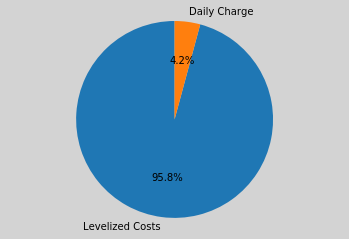

Total roof area of the  building: 599 m²
Total roof area used 437 m²
Percentage: 73.0%
[[250, 170, 150, 51, 21, 56, 0.8999999999999999, 0.7, 0.49999999999999994, 3169.97, 305.764, 0.0, 305.764, 0.0, {'Levelized Costs': 3036.906, 'Energy Charge': 0.02199999999999136, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60129347076, 61845.7, 436.806]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 115, 140, 36, 31, 51, 0.49999999999999994, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.204456567764282 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5633182525634766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.544605255126953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [295.83, 0.0, 0.0]


ERROR:ga_logger:Cost: 3071.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


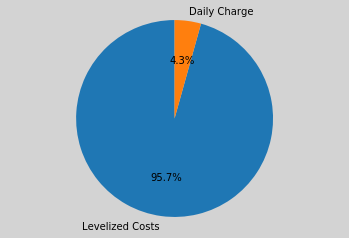

Total roof area of the  building: 599 m²
Total roof area used 592 m²
Percentage: 98.8%
[[185, 115, 140, 36, 31, 51, 0.49999999999999994, 0.5999999999999999, 0.7499999999999998, 3071.29, 295.83, 295.83, 0.0, 0.0, {'Levelized Costs': 2938.23, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60212743698, 61845.7, 591.659]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 260, 260, 11, 31, 31, 0.5999999999999999, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.227548837661743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6502513885498047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4700160026550293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [331.9, 0.0, 0.0]


ERROR:ga_logger:Cost: 3429.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 43,719 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,430 per year


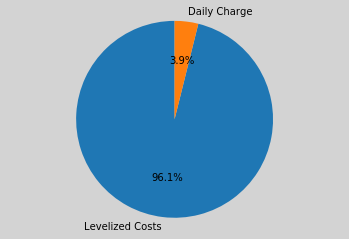

Total roof area of the  building: 599 m²
Total roof area used 553 m²
Percentage: 92.4%
[[250, 260, 260, 11, 31, 31, 0.5999999999999999, 0.44999999999999996, 0.7, 3429.56, 331.9, 331.9, 0.0, 0.0, {'Levelized Costs': 3296.5054999999998, 'Energy Charge': 0.012500000000045475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5992666427, 43719.0, 553.167]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 95, 100, 36, 31, 51, 0.5499999999999999, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.28929591178894 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4374544620513916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.465927839279175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [305.876, 0.0, 0.0]


ERROR:ga_logger:Cost: 3171.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


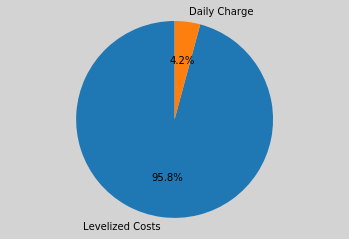

Total roof area of the  building: 599 m²
Total roof area used 556 m²
Percentage: 92.9%
[[155, 95, 100, 36, 31, 51, 0.5499999999999999, 0.7499999999999998, 0.5499999999999999, 3171.08, 305.876, 305.876, 0.0, 0.0, {'Levelized Costs': 3038.0229999999997, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600876249846, 61845.7, 556.138]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 90, 225, 21, 51, 46, 0.5999999999999999, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.157215118408203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418708324432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4544155597686768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [314.906, 0.0, 0.0]


ERROR:ga_logger:Cost: 3260.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,261 per year


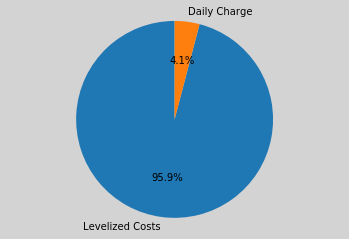

Total roof area of the  building: 599 m²
Total roof area used 525 m²
Percentage: 87.7%
[[135, 90, 225, 21, 51, 46, 0.5999999999999999, 0.49999999999999994, 0.3, 3260.77, 314.906, 314.906, 0.0, 0.0, {'Levelized Costs': 3127.709, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60290652008, 61845.7, 524.844]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 240, 230, 1, 46, 1, 0.7999999999999998, 0.39999999999999997, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.28517746925354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4370944499969482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.462510824203491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [16.7234, 0.0, 317.822]


ERROR:ga_logger:Cost: 3455.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,456 per year


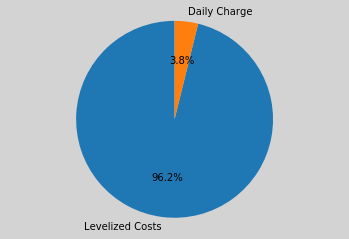

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 240, 230, 1, 46, 1, 0.7999999999999998, 0.39999999999999997, 0.5499999999999999, 3455.82, 334.54540000000003, 16.7234, 0.0, 317.822, {'Levelized Costs': 3322.761, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60214692564, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 160, 255, 11, 6, 16, 0.7499999999999998, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.956618309020996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3779399394989014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5709290504455566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 320.787, 0.0]


ERROR:ga_logger:Cost: 3319.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


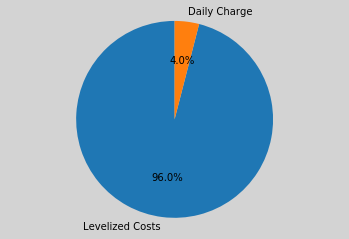

Total roof area of the  building: 599 m²
Total roof area used 583 m²
Percentage: 97.4%
[[230, 160, 255, 11, 6, 16, 0.7499999999999998, 0.5499999999999999, 0.7499999999999998, 3319.18, 320.787, 0.0, 320.787, 0.0, {'Levelized Costs': 3186.1169999999997, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60183722019, 61845.7, 583.25]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 215, 185, 21, 41, 41, 0.8499999999999999, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.30231785774231 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5609183311462402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.522641897201538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 128.653, 184.945]


ERROR:ga_logger:Cost: 3247.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,248 per year


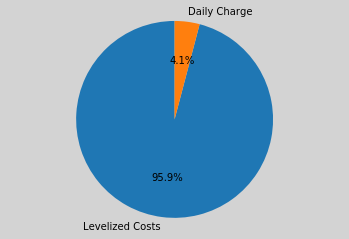

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 215, 185, 21, 41, 41, 0.8499999999999999, 0.35, 0.7999999999999998, 3247.78, 313.59799999999996, 0.0, 128.653, 184.945, {'Levelized Costs': 3114.7210000000005, 'Energy Charge': 0.016999999999825377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59943561044, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 145, 260, 56, 51, 11, 0.3, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.34705376625061 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4815845489501953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4858174324035645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3777.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0108 /kWh
Total Cost of the system: $ 3,778 per year


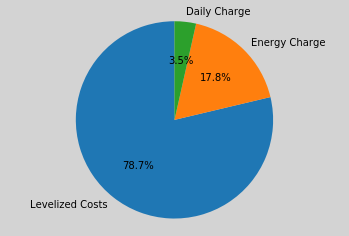

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 145, 260, 56, 51, 11, 0.3, 0.49999999999999994, 0.25, 3777.58, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.513, 'Energy Charge': 671.025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56490.35572539995, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 195, 115, 51, 1, 46, 0.2, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.284088373184204 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5003178119659424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4664552211761475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 329.319, 0.0]


ERROR:ga_logger:Cost: 3499.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0015 /kWh
Total Cost of the system: $ 3,500 per year


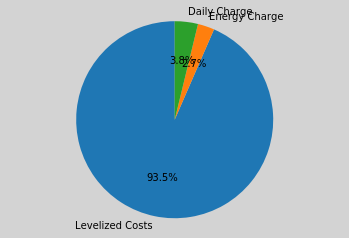

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 195, 115, 51, 1, 46, 0.2, 0.5499999999999999, 0.25, 3499.57, 329.319, 0.0, 329.319, 0.0, {'Levelized Costs': 3270.855, 'Energy Charge': 95.67300000000017, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61082.25402911172, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 250, 245, 6, 46, 46, 0.5499999999999999, 0.3, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.24474835395813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454766035079956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5825605392456055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [324.002, 0.0, 0.0]


ERROR:ga_logger:Cost: 3351.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


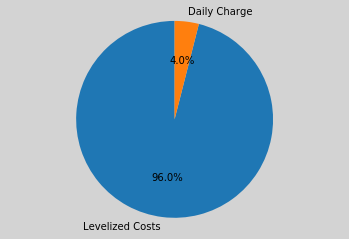

Total roof area of the  building: 599 m²
Total roof area used 589 m²
Percentage: 98.4%
[[215, 250, 245, 6, 46, 46, 0.5499999999999999, 0.3, 0.35, 3351.11, 324.002, 324.002, 0.0, 0.0, {'Levelized Costs': 3218.053, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59934096468, 61845.7, 589.095]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 105, 240, 21, 26, 11, 0.7, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.926583766937256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4737091064453125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.370836973190308 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [303.969, 0.0, 0.0]


ERROR:ga_logger:Cost: 3152.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,152 per year


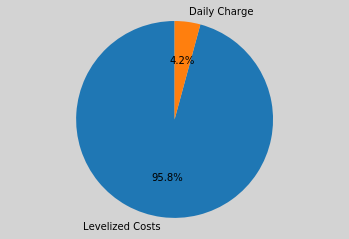

Total roof area of the  building: 599 m²
Total roof area used 434 m²
Percentage: 72.5%
[[185, 105, 240, 21, 26, 11, 0.7, 0.39999999999999997, 0.7499999999999998, 3152.13, 303.969, 303.969, 0.0, 0.0, {'Levelized Costs': 3019.069, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602082184516, 61845.7, 434.241]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 250, 165, 21, 6, 51, 0.8499999999999999, 0.7999999999999998, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.209965705871582 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410409450531006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3679563999176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 232.318, 92.5093]


ERROR:ga_logger:Cost: 3359.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,359 per year


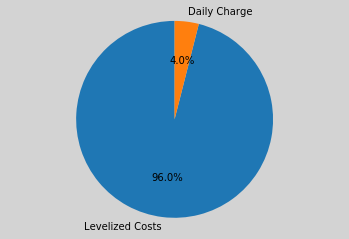

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 250, 165, 21, 6, 51, 0.8499999999999999, 0.7999999999999998, 0.3, 3359.31, 324.82730000000004, 0.0, 232.318, 92.5093, {'Levelized Costs': 3226.255, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60045705978, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 165, 125, 21, 16, 56, 0.5499999999999999, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.891940355300903 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4562902450561523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.501765251159668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [299.254, 0.0, 0.0]


ERROR:ga_logger:Cost: 3105.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,105 per year


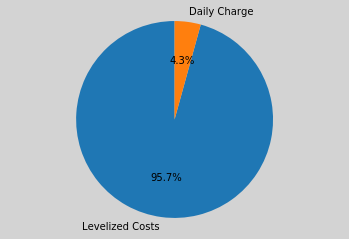

Total roof area of the  building: 599 m²
Total roof area used 544 m²
Percentage: 90.9%
[[185, 165, 125, 21, 16, 56, 0.5499999999999999, 0.6499999999999999, 0.7999999999999998, 3105.31, 299.254, 299.254, 0.0, 0.0, {'Levelized Costs': 2972.2499999999995, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59946453236, 61845.7, 544.099]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 265, 155, 11, 21, 16, 0.49999999999999994, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.736246585845947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.161954164505005 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4772493839263916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 3432.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0053 /kWh
Total Cost of the system: $ 3,433 per year


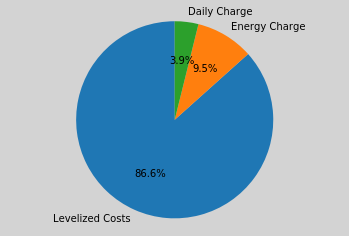

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 265, 155, 11, 21, 16, 0.49999999999999994, 0.35, 0.44999999999999996, 3432.51, 299.381, 299.381, 0.0, 0.0, {'Levelized Costs': 2973.5020000000004, 'Energy Charge': 325.96600000000007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59244.31418731371, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 200, 100, 56, 16, 6, 0.39999999999999997, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.46848464012146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6533708572387695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5145983695983887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 312.276, 0.0]


ERROR:ga_logger:Cost: 3234.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


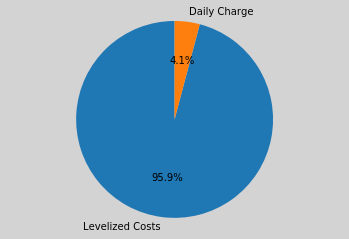

Total roof area of the  building: 599 m²
Total roof area used 416 m²
Percentage: 69.5%
[[220, 200, 100, 56, 16, 6, 0.39999999999999997, 0.7499999999999998, 0.5499999999999999, 3234.65, 312.276, 0.0, 312.276, 0.0, {'Levelized Costs': 3101.5939999999996, 'Energy Charge': 0.014000000000407908, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60217610912, 61845.7, 416.368]]


ERROR:optimizer_logger:160


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 90, 140, 36, 26, 36, 0.8499999999999999, 0.3, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.394717216491699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437617063522339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4891903400421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [282.987, 0.0, 79.7508]


ERROR:ga_logger:Cost: 3735.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,736 per year


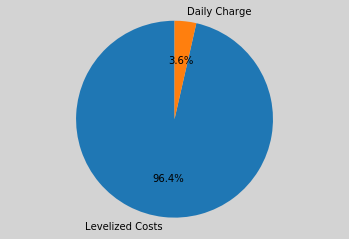

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 90, 140, 36, 26, 36, 0.8499999999999999, 0.3, 0.3, 3735.84, 362.7378, 282.987, 0.0, 79.7508, {'Levelized Costs': 3602.789, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60012024017, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 220, 165, 36, 26, 31, 0.2, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.409900665283203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5311834812164307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.478437662124634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 147.623, 160.772]


ERROR:ga_logger:Cost: 3196.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,196 per year


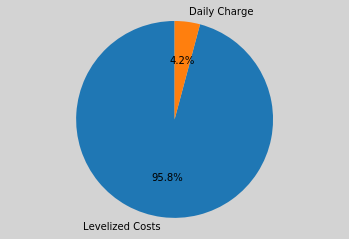

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 220, 165, 36, 26, 31, 0.2, 0.7499999999999998, 0.39999999999999997, 3196.1, 308.395, 0.0, 147.623, 160.772, {'Levelized Costs': 3063.0389999999998, 'Energy Charge': 0.0190000000000623, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60165221308, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 135, 150, 21, 31, 46, 0.6499999999999999, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.388251066207886 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6806721687316895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4460647106170654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [159.273, 0.0, 159.177]


ERROR:ga_logger:Cost: 3295.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,296 per year


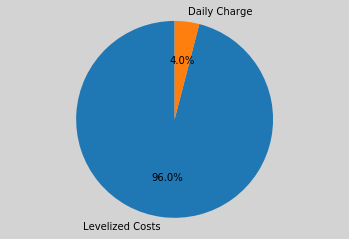

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 135, 150, 21, 31, 46, 0.6499999999999999, 0.3, 0.44999999999999996, 3295.97, 318.45, 159.273, 0.0, 159.177, {'Levelized Costs': 3162.9129999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60518376987, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 140, 155, 26, 31, 41, 0.39999999999999997, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.458907842636108 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5590689182281494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5309715270996094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [239.505, 0.0, 0.0]


ERROR:ga_logger:Cost: 3998.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0240 /kWh
Total Cost of the system: $ 3,999 per year


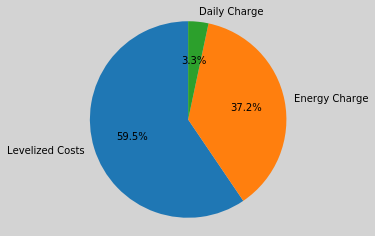

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[160, 140, 155, 26, 31, 41, 0.39999999999999997, 0.39999999999999997, 0.35, 3998.95, 239.505, 239.505, 0.0, 0.0, {'Levelized Costs': 2378.81, 'Energy Charge': 1487.098, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49977.41864760012, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 110, 160, 51, 21, 51, 0.49999999999999994, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.423730373382568 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.53460431098938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.48457932472229 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 209.277, 119.918]


ERROR:ga_logger:Cost: 3402.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,403 per year


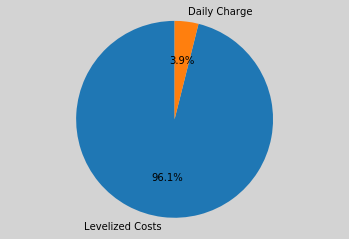

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 110, 160, 51, 21, 51, 0.49999999999999994, 0.7, 0.39999999999999997, 3402.69, 329.195, 0.0, 209.277, 119.918, {'Levelized Costs': 3269.637, 'Energy Charge': 0.011000000000024102, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60208046, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 200, 240, 26, 16, 26, 0.25, 0.2, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.541776895523071 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.784238815307617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.477280378341675 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 179.629]


ERROR:ga_logger:Cost: 5351.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0555 /kWh
Total Cost of the system: $ 5,352 per year


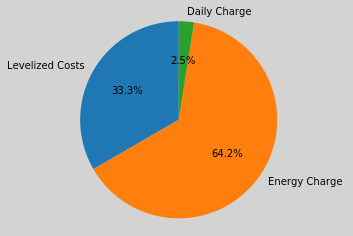

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 200, 240, 26, 16, 26, 0.25, 0.2, 0.3, 5351.53, 179.629, 0.0, 0.0, 179.629, {'Levelized Costs': 1784.1021999999994, 'Energy Charge': 3434.3858000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 34436.41803349164, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 165, 265, 26, 6, 51, 0.5499999999999999, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.526689291000366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6967790126800537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.754855155944824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [329.319, 0.0, 0.0]


ERROR:ga_logger:Cost: 3453.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0008 /kWh
Total Cost of the system: $ 3,453 per year


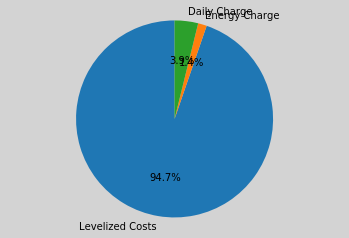

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 165, 265, 26, 6, 51, 0.5499999999999999, 0.3, 0.8499999999999999, 3453.33, 329.319, 329.319, 0.0, 0.0, {'Levelized Costs': 3270.867, 'Energy Charge': 49.420999999999935, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61451.24911432997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 200, 245, 31, 31, 21, 0.35, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.368367433547974 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4155051708221436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9841549396514893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  66 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 136s


ERROR:ga_logger:panel relevance: [0.0, 166.324, 155.509]


ERROR:ga_logger:Cost: 3329.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


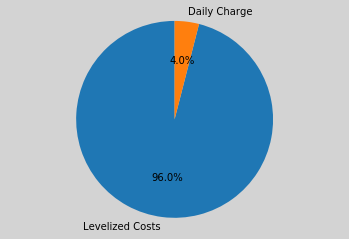

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 200, 245, 31, 31, 21, 0.35, 0.39999999999999997, 0.8499999999999999, 3329.57, 321.83299999999997, 0.0, 166.324, 155.509, {'Levelized Costs': 3196.5129999999995, 'Energy Charge': 0.015000000000554792, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085102267, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 95, 220, 26, 21, 36, 0.8999999999999999, 0.6499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 26.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.299193620681763 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.321171760559082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3443446159362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [145.598, 0.0, 174.795]


ERROR:ga_logger:Cost: 3315.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


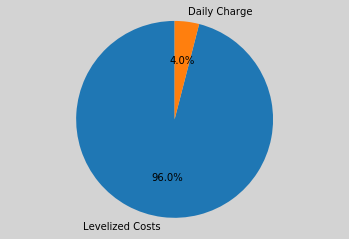

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 95, 220, 26, 21, 36, 0.8999999999999999, 0.6499999999999999, 0.39999999999999997, 3315.26, 320.39300000000003, 145.598, 0.0, 174.795, {'Levelized Costs': 3182.2020000000007, 'Energy Charge': 0.015999999999849024, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600575408665, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 110, 140, 6, 6, 11, 0.3, 0.7999999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.639161109924316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3404457569122314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.466747283935547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 322.223]


ERROR:ga_logger:Cost: 3333.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,333 per year


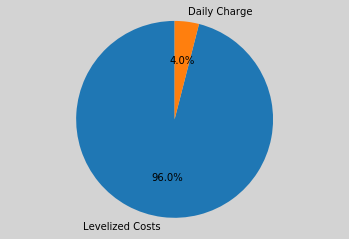

Total roof area of the  building: 599 m²
Total roof area used 403 m²
Percentage: 67.3%
[[125, 110, 140, 6, 6, 11, 0.3, 0.7999999999999998, 0.7999999999999998, 3333.44, 322.223, 0.0, 0.0, 322.223, {'Levelized Costs': 3200.384, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60295071, 61845.7, 402.779]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 240, 255, 46, 46, 26, 0.8999999999999999, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.358930587768555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.399289846420288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5325841903686523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [222.628, 0.0, 140.559]


ERROR:ga_logger:Cost: 3740.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,740 per year


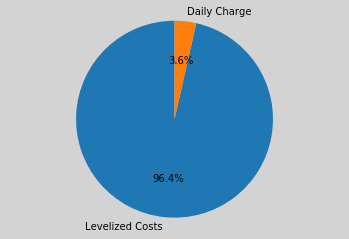

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 240, 255, 46, 46, 26, 0.8999999999999999, 0.7999999999999998, 0.39999999999999997, 3740.3, 363.187, 222.628, 0.0, 140.559, {'Levelized Costs': 3607.242, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60060298994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 255, 225, 26, 51, 41, 0.25, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.421710968017578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.405951976776123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419084310531616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 349.906]


ERROR:ga_logger:Cost: 3608.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,608 per year


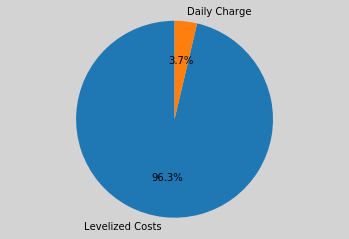

Total roof area of the  building: 599 m²
Total roof area used 467 m²
Percentage: 77.9%
[[265, 255, 225, 26, 51, 41, 0.25, 0.5499999999999999, 0.7499999999999998, 3608.39, 349.906, 0.0, 0.0, 349.906, {'Levelized Costs': 3475.332, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60126259511, 61845.7, 466.541]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 135, 265, 6, 36, 16, 0.39999999999999997, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.36620569229126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.411907911300659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.435579776763916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [97.1795, 231.278, 0.0]


ERROR:ga_logger:Cost: 3395.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,395 per year


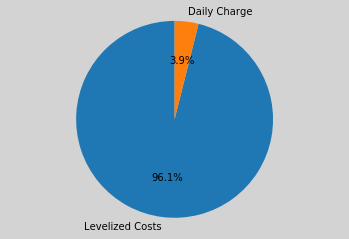

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 135, 265, 6, 36, 16, 0.39999999999999997, 0.6499999999999999, 0.8999999999999999, 3395.37, 328.4575, 97.1795, 231.278, 0.0, {'Levelized Costs': 3262.31, 'Energy Charge': 0.01799999999997226, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60183867613, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 195, 160, 6, 31, 41, 0.5499999999999999, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.321019887924194 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3660078048706055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.401901960372925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 3232.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0020 /kWh
Total Cost of the system: $ 3,233 per year


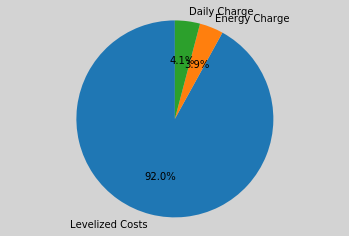

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 195, 160, 6, 31, 41, 0.5499999999999999, 0.25, 0.49999999999999994, 3232.89, 299.381, 0.0, 0.0, 299.381, {'Levelized Costs': 2973.5129999999995, 'Energy Charge': 126.33500000000026, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60837.43625610019, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 135, 240, 41, 6, 46, 0.3, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4011993408203125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385253429412842 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3799781799316406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 115.362, 239.225]


ERROR:ga_logger:Cost: 3654.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,655 per year


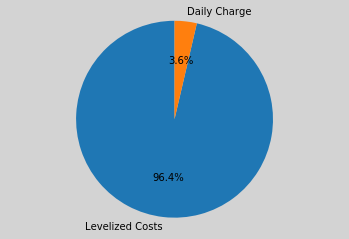

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 135, 240, 41, 6, 46, 0.3, 0.49999999999999994, 0.6499999999999999, 3654.88, 354.587, 0.0, 115.362, 239.225, {'Levelized Costs': 3521.831, 'Energy Charge': 0.006999999999891315, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60157961895, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 150, 90, 31, 6, 26, 0.25, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.413758754730225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3371262550354004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366219997406006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [59.9291, 0.0, 323.141]


ERROR:ga_logger:Cost: 3937.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,938 per year


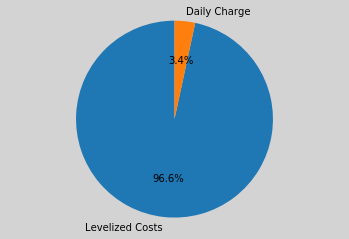

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[180, 150, 90, 31, 6, 26, 0.25, 0.25, 0.8999999999999999, 3937.78, 383.0701, 59.9291, 0.0, 323.141, {'Levelized Costs': 3804.7280000000005, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600882300234, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 230, 145, 16, 31, 51, 0.8999999999999999, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.05412220954895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4233715534210205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.34114933013916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [237.847, 0.0, 83.6217]


ERROR:ga_logger:Cost: 3325.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,326 per year


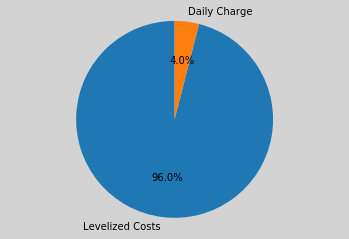

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 230, 145, 16, 31, 51, 0.8999999999999999, 0.8999999999999999, 0.25, 3325.95, 321.4687, 237.847, 0.0, 83.6217, {'Levelized Costs': 3192.899, 'Energy Charge': 0.008999999999787178, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599034514096, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 255, 245, 1, 51, 51, 0.5499999999999999, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.463008642196655 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.346130609512329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3775479793548584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [329.319, 0.0, 0.0]


ERROR:ga_logger:Cost: 3519.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0019 /kWh
Total Cost of the system: $ 3,520 per year


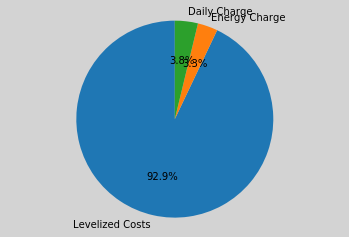

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[225, 255, 245, 1, 51, 51, 0.5499999999999999, 0.7499999999999998, 0.3, 3519.87, 329.319, 329.319, 0.0, 0.0, {'Levelized Costs': 3270.8579999999997, 'Energy Charge': 115.97000000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60920.20918749389, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 130, 235, 21, 26, 6, 0.44999999999999996, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.462891578674316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378701686859131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512413740158081 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 3789.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0110 /kWh
Total Cost of the system: $ 3,790 per year


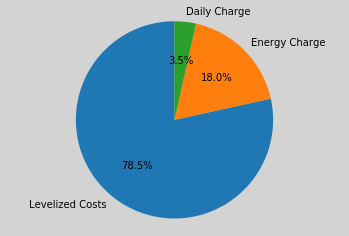

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 130, 235, 21, 26, 6, 0.44999999999999996, 0.44999999999999996, 0.49999999999999994, 3789.87, 299.381, 0.0, 0.0, 299.381, {'Levelized Costs': 2973.507, 'Energy Charge': 683.3209999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56392.26653431295, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 205, 255, 41, 56, 26, 0.2, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.540610313415527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3592629432678223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5060601234436035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 239.505, 0.0]


ERROR:ga_logger:Cost: 4521.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0325 /kWh
Total Cost of the system: $ 4,521 per year


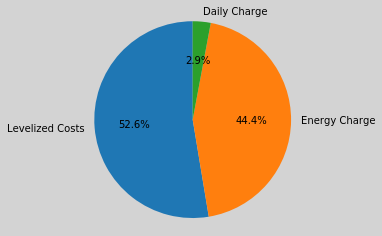

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 205, 255, 41, 56, 26, 0.2, 0.39999999999999997, 0.3, 4521.14, 239.505, 0.0, 239.505, 0.0, {'Levelized Costs': 2378.8070000000002, 'Energy Charge': 2009.2910000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 45809.86514236071, 61845.7, 598.762]]


ERROR:optimizer_logger:180


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 135, 150, 51, 41, 16, 0.8999999999999999, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.465640306472778 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3490281105041504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3435258865356445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [176.799, 160.928, 0.0]


ERROR:ga_logger:Cost: 3487.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,487 per year


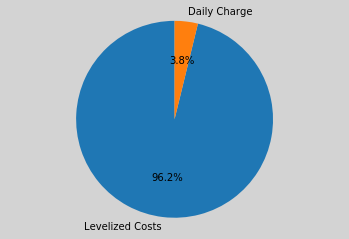

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 135, 150, 51, 41, 16, 0.8999999999999999, 0.39999999999999997, 0.25, 3487.42, 337.727, 176.799, 160.928, 0.0, {'Levelized Costs': 3354.36, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60184725994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 105, 145, 26, 46, 36, 0.35, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.543737411499023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37066388130188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4959492683410645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [131.871, 0.0, 199.789]


ERROR:ga_logger:Cost: 3427.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,427 per year


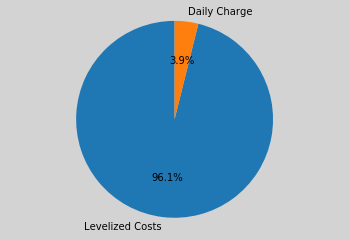

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 105, 145, 26, 46, 36, 0.35, 0.7499999999999998, 0.8999999999999999, 3427.17, 331.65999999999997, 131.871, 0.0, 199.789, {'Levelized Costs': 3294.105, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602473435996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 100, 185, 16, 56, 26, 0.7, 0.49999999999999994, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.569898843765259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.379096031188965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42354679107666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.926]


ERROR:ga_logger:Cost: 3082.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,082 per year


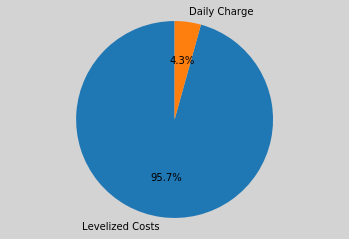

Total roof area of the  building: 599 m²
Total roof area used 540 m²
Percentage: 90.2%
[[215, 100, 185, 16, 56, 26, 0.7, 0.49999999999999994, 0.5499999999999999, 3082.18, 296.926, 0.0, 0.0, 296.926, {'Levelized Costs': 2949.124, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60133061498, 61845.7, 539.865]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 265, 155, 36, 21, 11, 0.8499999999999999, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.501003265380859 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.04366135597229 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.409510374069214 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 312.563]


ERROR:ga_logger:Cost: 3237.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,237 per year


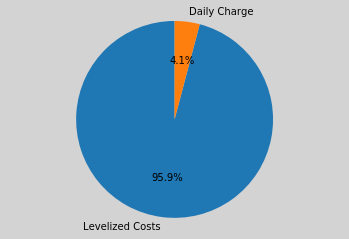

Total roof area of the  building: 599 m²
Total roof area used 568 m²
Percentage: 94.9%
[[265, 265, 155, 36, 21, 11, 0.8499999999999999, 0.35, 0.5499999999999999, 3237.49, 312.563, 0.0, 0.0, 312.563, {'Levelized Costs': 3104.435, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59826740012, 61845.7, 568.296]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 240, 240, 51, 11, 51, 0.7, 0.5499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.615323543548584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.825254201889038 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3630051612854004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 326.472, 0.0]


ERROR:ga_logger:Cost: 3375.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,376 per year


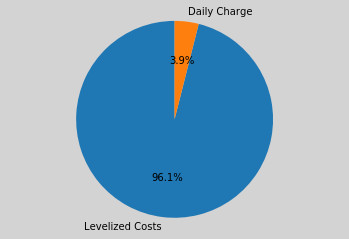

Total roof area of the  building: 599 m²
Total roof area used 594 m²
Percentage: 99.1%
[[110, 240, 240, 51, 11, 51, 0.7, 0.5499999999999999, 0.3, 3375.64, 326.472, 0.0, 326.472, 0.0, {'Levelized Costs': 3242.5839999999994, 'Energy Charge': 0.014000000000464752, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59945585905, 61845.7, 593.585]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 230, 175, 56, 41, 31, 0.25, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.544313669204712 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3709053993225098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.38614559173584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 225.863, 110.752]


ERROR:ga_logger:Cost: 3476.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,476 per year


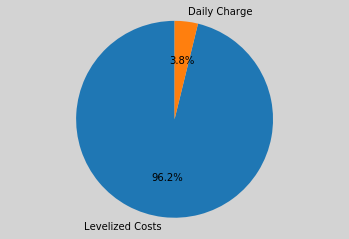

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 230, 175, 56, 41, 31, 0.25, 0.7999999999999998, 0.35, 3476.38, 336.615, 0.0, 225.863, 110.752, {'Levelized Costs': 3343.329, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599480121, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 175, 180, 36, 1, 36, 0.25, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.628122329711914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4379239082336426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4921343326568604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 179.629]


ERROR:ga_logger:Cost: 4885.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0480 /kWh
Total Cost of the system: $ 4,886 per year


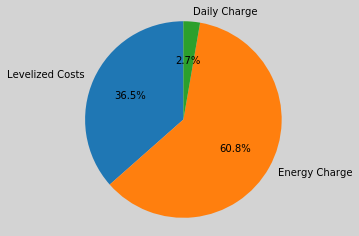

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 175, 180, 36, 1, 36, 0.25, 0.39999999999999997, 0.3, 4885.76, 179.629, 0.0, 0.0, 179.629, {'Levelized Costs': 1784.1090000000008, 'Energy Charge': 2968.6089999999995, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 38153.69357619993, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 95, 120, 21, 31, 21, 0.5499999999999999, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.622892379760742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3900434970855713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3943374156951904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [316.542, 0.0, 20.9075]


ERROR:ga_logger:Cost: 3484.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,485 per year


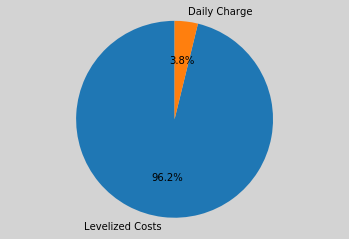

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 95, 120, 21, 31, 21, 0.5499999999999999, 0.25, 0.8999999999999999, 3484.67, 337.44949999999994, 316.542, 0.0, 20.9075, {'Levelized Costs': 3351.6040000000003, 'Energy Charge': 0.023999999999773536, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60123296, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 230, 105, 6, 11, 1, 0.5999999999999999, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.677353858947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8035740852355957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.564915180206299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [320.496, 0.0, 0.0]


ERROR:ga_logger:Cost: 3316.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,316 per year


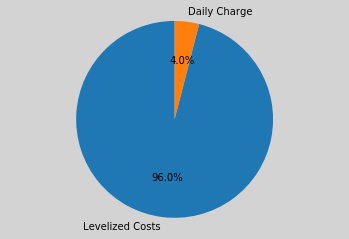

Total roof area of the  building: 599 m²
Total roof area used 534 m²
Percentage: 89.2%
[[185, 230, 105, 6, 11, 1, 0.5999999999999999, 0.6499999999999999, 0.5999999999999999, 3316.29, 320.496, 320.496, 0.0, 0.0, {'Levelized Costs': 3183.229, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60225592127, 61845.7, 534.16]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 100, 185, 11, 21, 26, 0.2, 0.7999999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.56265926361084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.376375198364258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4811041355133057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.168]


ERROR:ga_logger:Cost: 3173.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,174 per year


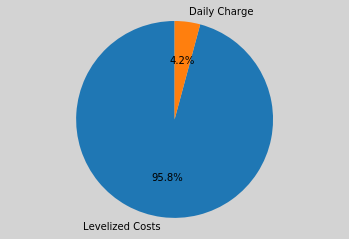

Total roof area of the  building: 599 m²
Total roof area used 408 m²
Percentage: 68.2%
[[180, 100, 185, 11, 21, 26, 0.2, 0.7999999999999998, 0.7499999999999998, 3173.98, 306.168, 0.0, 0.0, 306.168, {'Levelized Costs': 3040.929, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085441469, 61845.7, 408.225]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 255, 260, 26, 11, 56, 0.25, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.57166862487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5039095878601074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5161049365997314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4297.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0241 /kWh
Total Cost of the system: $ 4,298 per year


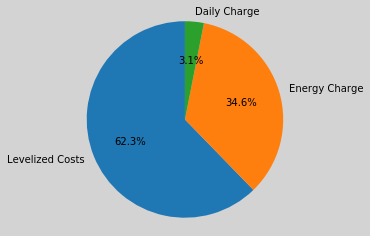

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 255, 260, 26, 11, 56, 0.25, 0.44999999999999996, 0.7499999999999998, 4297.62, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.161, 'Energy Charge': 1488.417, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49966.88043564107, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 215, 230, 46, 36, 41, 0.5499999999999999, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.66174840927124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366736650466919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4484033584594727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [276.97, 38.0718, 0.0]


ERROR:ga_logger:Cost: 3262.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,262 per year


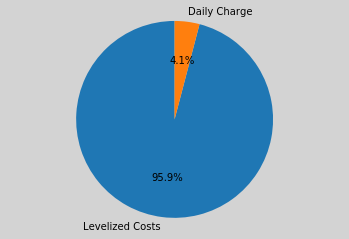

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 215, 230, 46, 36, 41, 0.5499999999999999, 0.39999999999999997, 0.35, 3262.12, 315.0418, 276.97, 38.0718, 0.0, {'Levelized Costs': 3129.0660000000003, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602773562205, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 240, 240, 56, 11, 56, 0.35, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.626654863357544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6898269653320312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.582041025161743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [93.449, 232.235, 0.0]


ERROR:ga_logger:Cost: 3367.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,368 per year


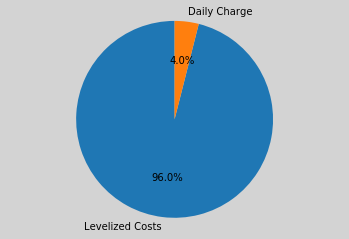

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 240, 240, 56, 11, 56, 0.35, 0.7, 0.7499999999999998, 3367.82, 325.684, 93.449, 232.235, 0.0, {'Levelized Costs': 3234.771, 'Energy Charge': 0.007000000000289219, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6032665377, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 170, 160, 41, 6, 36, 0.5999999999999999, 0.44999999999999996, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.631536960601807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3401687145233154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.415902853012085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4036.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0198 /kWh
Total Cost of the system: $ 4,036 per year


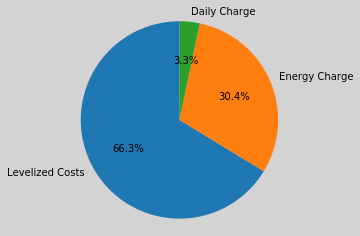

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 170, 160, 41, 6, 36, 0.5999999999999999, 0.44999999999999996, 0.3, 4036.38, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.1620000000003, 'Energy Charge': 1227.176, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 52051.774539501916, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 150, 160, 36, 16, 11, 0.8999999999999999, 0.25, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.67560887336731 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.348351001739502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471959352493286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 80.4259, 235.499]


ERROR:ga_logger:Cost: 3270.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,271 per year


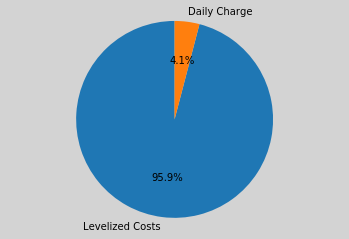

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 150, 160, 36, 16, 11, 0.8999999999999999, 0.25, 0.8499999999999999, 3270.89, 315.9249, 0.0, 80.4259, 235.499, {'Levelized Costs': 3137.83, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59923007721, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 200, 195, 46, 1, 16, 0.44999999999999996, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.779212951660156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5568830966949463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4690113067626953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 16.6755, 289.572]


ERROR:ga_logger:Cost: 3174.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,175 per year


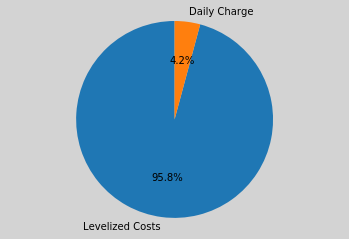

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 200, 195, 46, 1, 16, 0.44999999999999996, 0.8499999999999999, 0.49999999999999994, 3174.77, 306.2475, 0.0, 16.6755, 289.572, {'Levelized Costs': 3041.7149999999997, 'Energy Charge': 0.013000000000488399, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111238542, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 215, 205, 41, 41, 1, 0.5499999999999999, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.763866186141968 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6098673343658447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.43886137008667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 326.848, 0.0]


ERROR:ga_logger:Cost: 3379.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,379 per year


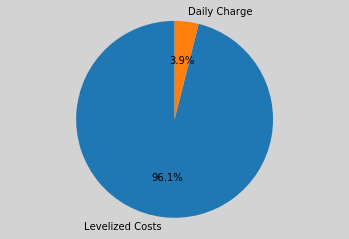

Total roof area of the  building: 599 m²
Total roof area used 503 m²
Percentage: 84.0%
[[235, 215, 205, 41, 41, 1, 0.5499999999999999, 0.6499999999999999, 0.44999999999999996, 3379.37, 326.848, 0.0, 326.848, 0.0, {'Levelized Costs': 3246.314, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60388705415, 61845.7, 502.842]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 150, 220, 16, 6, 11, 0.44999999999999996, 0.2, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.71534276008606 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42891263961792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.861544370651245 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 3560.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0073 /kWh
Total Cost of the system: $ 3,560 per year


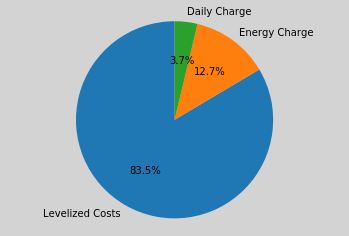

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 150, 220, 16, 6, 11, 0.44999999999999996, 0.2, 0.49999999999999994, 3560.1, 299.381, 0.0, 0.0, 299.381, {'Levelized Costs': 2973.5029999999997, 'Energy Charge': 453.55500000000023, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58226.00325089671, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 250, 190, 51, 51, 46, 0.6499999999999999, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.781351327896118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3965237140655518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.41561222076416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.824]


ERROR:ga_logger:Cost: 3369.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,369 per year


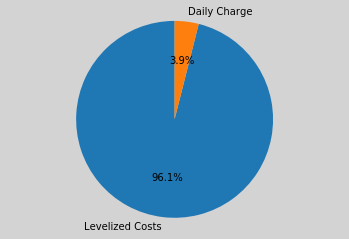

Total roof area of the  building: 599 m²
Total roof area used 407 m²
Percentage: 68.0%
[[235, 250, 190, 51, 51, 46, 0.6499999999999999, 0.3, 0.7999999999999998, 3369.21, 325.824, 0.0, 0.0, 325.824, {'Levelized Costs': 3236.1549999999997, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602048362285, 61845.7, 407.28]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 160, 165, 41, 46, 11, 0.5499999999999999, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.735976934432983 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389068126678467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3856008052825928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 316.713, 0.0]


ERROR:ga_logger:Cost: 3278.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,279 per year


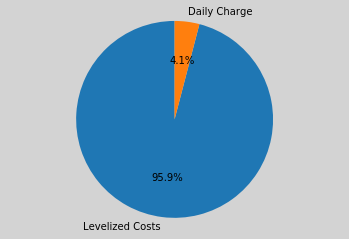

Total roof area of the  building: 599 m²
Total roof area used 528 m²
Percentage: 88.2%
[[110, 160, 165, 41, 46, 11, 0.5499999999999999, 0.5999999999999999, 0.8999999999999999, 3278.71, 316.713, 0.0, 316.713, 0.0, {'Levelized Costs': 3145.651, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60099880005, 61845.7, 527.855]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Time in minutes for the 200 runs frequency 5:


ERROR:Runs_logger:1073.0910656015078


In [26]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_file=ehub_file,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)
if (runs_num ==1):
    init_pop=1
else:
    init_pop=20
    
pvoptimizer.runGA(runs_num,init_pop,"BC","DUAL")
pvoptimizer.processGA(ga_fina)
# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Time in minutes for the {} runs frequency {}:".format(runs_num,run_i))
lrun.error(mintime)
